<a href="https://colab.research.google.com/github/javmencia/COBWEBfiles/blob/main/180DaySurvivalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.9 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=5875d166bd6af330b406958714a01ca9d6174e0599eba8502bba2cd96bcc1a05
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [10]:
pip install scikit-survival

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 222.1/222.1 kB 8.4 MB/s eta 0:00:00


## LSTM Discrete Survival

balanced batch 1:1

Training Temporal Autoencoder for Imputation...
139/139 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step
Training Survival LSTM...
139/139 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step

METRIC                              | VALUE      | 95% CI / INFO       
---------------------------------------------------------------------------
Concordance Index                   | 0.8449      | Discrimination
Sensitivity                         | 0.8592      | [0.825, 0.888]
Specificity                         | 0.8592      | [0.848, 0.870]
PPV                                 | 0.4230      | [0.392, 0.454]
Balanced Accuracy                   | 0.8592      | [0.849, 0.869]

----------------------------------------
CALIBRATION LINE STATISTICS
----------------------------------------
Slope:                    0.7929
Intercept:                -0.1802
R-squared:                0.8020
----------------------------------------



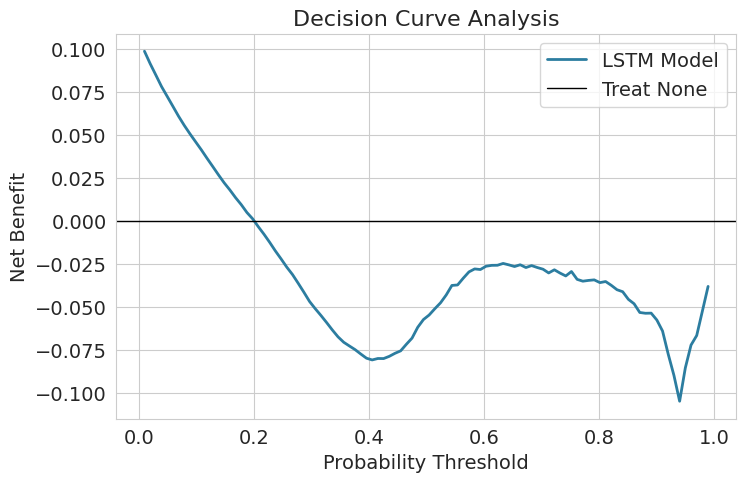

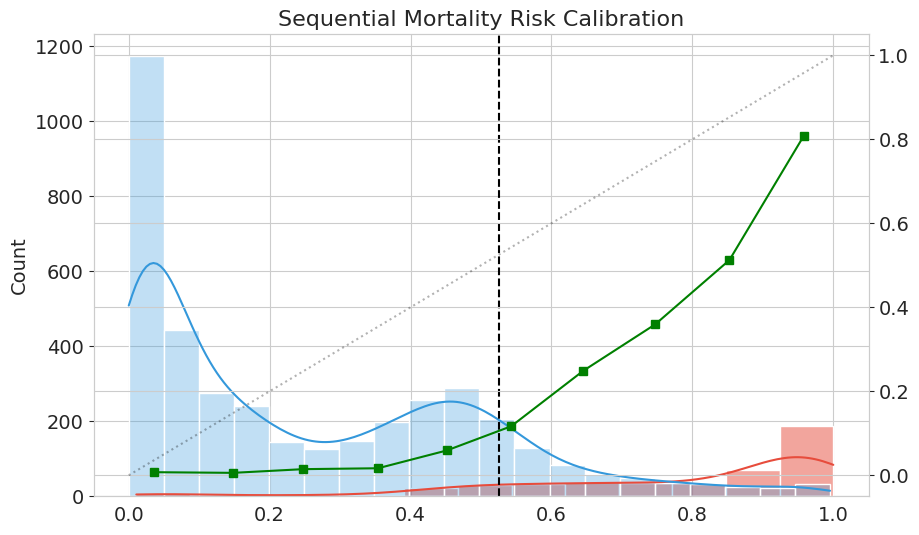

Calculating Permutation Feature Importance...


/tmp/ipython-input-1800724480.py:199: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  plot = sns.barplot(x='Drop in C-index', y='Feature', data=importance_df, palette='viridis')


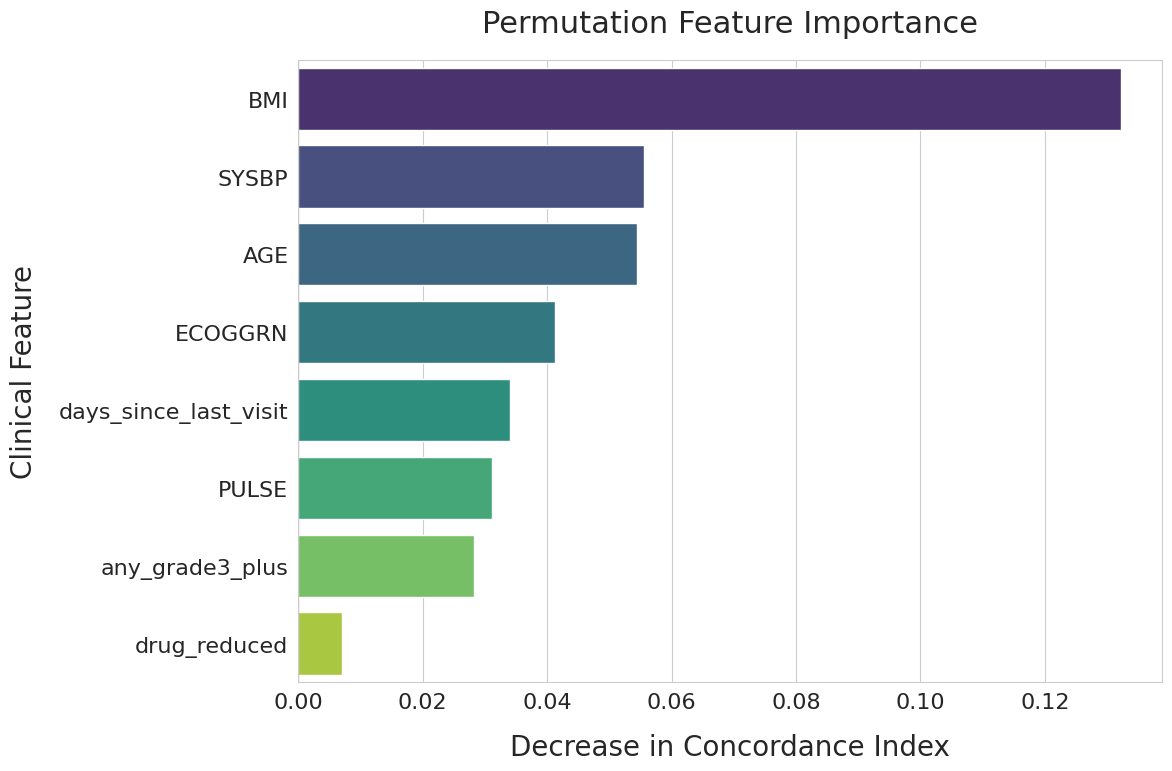

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from lifelines.utils import concordance_index
from scipy import stats
import random

# Consistency
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

def masked_mse(y_true, y_pred):
    """Calculates MSE only on non-missing values (where y_true != -999)."""
    mask = tf.cast(tf.not_equal(y_true, -999), tf.float32)
    return tf.reduce_sum(tf.square(y_true - y_pred) * mask) / (tf.reduce_sum(mask) + 1e-7)

class SequentialSurvivalLSTM:
    def __init__(self, sequence_length=12, horizon=180):
        self.sequence_length = sequence_length
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.autoencoder = None
        self.model = None

    def train_autoencoder(self, X_with_nan):
        """Trains the autoencoder to reconstruct missing values."""
        print("Training Temporal Autoencoder for Imputation...")
        X_train = np.nan_to_num(X_with_nan, nan=-999)

        ae_model = Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            layers.LSTM(64, return_sequences=True),
            layers.LSTM(32, return_sequences=False),
            layers.RepeatVector(self.sequence_length),
            layers.LSTM(32, return_sequences=True),
            layers.LSTM(64, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.input_dim))
        ])

        ae_model.compile(optimizer='adam', loss=masked_mse)
        ae_model.fit(X_train, X_train, epochs=30, batch_size=32, verbose=0)
        self.autoencoder = ae_model

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_list, metadata = [], [], []

        df_temp = df.copy()
        self.scaler.fit(df_temp[self.feature_cols].fillna(df_temp[self.feature_cols].median()))

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = self.scaler.transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_seq = p_data[self.feature_cols].iloc[:i+1].values[-self.sequence_length:]

                if len(feat_seq) < self.sequence_length:
                    pad_width = self.sequence_length - len(feat_seq)
                    feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=np.nan)

                X_list.append(feat_seq)
                y_list.append(label)
                metadata.append({
                    'pid': pid, 'current_vday': current_vday, 'dsday': death_day,
                    'tte': time_to_death if has_event else (last_fup - current_vday),
                    'event': 1 if has_event else 0
                })

        X_raw = np.array(X_list)
        if self.autoencoder is None:
            self.train_autoencoder(X_raw)

        X_masked = np.nan_to_num(X_raw, nan=-999)
        X_imputed_preds = self.autoencoder.predict(X_masked)
        X_final = np.where(np.isnan(X_raw), X_imputed_preds, X_raw)

        return X_final, np.array(y_list), metadata

    def balanced_batch_generator(self, X, y, batch_size=32):
        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]
        half_batch = batch_size // 2
        while True:
            batch_pos = np.random.choice(pos_idx, half_batch)
            batch_neg = np.random.choice(neg_idx, half_batch)
            indices = np.concatenate([batch_pos, batch_neg])
            np.random.shuffle(indices)
            X_batch = X[indices]
            y_batch = np.repeat(y[indices, np.newaxis, np.newaxis], self.sequence_length, axis=1)
            yield X_batch, y_batch

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.LSTM(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.LSTM(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)
        self.model = self.build_sequential_model()

        print(f"Training Survival LSTM...")
        self.model.fit(self.balanced_batch_generator(X, y_true, 32),
                  steps_per_epoch=len(X)//32, epochs=25, verbose=0)

        raw_preds = self.model.predict(X)
        visit_risks_raw = raw_preds[:, -1, 0]
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)

        # C-INDEX
        tte = np.array([m['tte'] for m in metadata])
        events = np.array([m['event'] for m in metadata])
        c_val = concordance_index(tte, 1 - visit_risks, events)

        # Threshold Optimization
        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        self.report_comprehensive_metrics(y_true, y_pred, c_val, metadata)
        self.calculate_calibration_stats(y_true, visit_risks)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)
        self.plot_permutation_importance(X, tte, events, c_val)

def plot_permutation_importance(self, X, tte, events, baseline_cindex):
    """Calculates and plots permutation importance based on C-index degradation."""
    print("Calculating Permutation Feature Importance...")

    # Increase global font size for PDF export
    plt.rcParams.update({'font.size': 16})

    importances = []

    for i, col in enumerate(self.feature_cols):
        X_permuted = X.copy()
        # Permute the specific feature across the entire batch
        shuffled_indices = np.random.permutation(len(X))
        X_permuted[:, :, i] = X_permuted[shuffled_indices, :, i]

        # Predict and calculate new C-index
        raw_preds = self.model.predict(X_permuted, verbose=0)
        perm_risks_raw = raw_preds[:, -1, 0]
        # Standardize for consistency
        perm_risks = self.final_scaler.transform(perm_risks_raw.reshape(-1, 1)).flatten()

        new_cindex = concordance_index(tte, 1 - perm_risks, events)
        importances.append(baseline_cindex - new_cindex)

    importance_df = pd.DataFrame({'Feature': self.feature_cols, 'Drop in C-index': importances})
    importance_df = importance_df.sort_values(by='Drop in C-index', ascending=False)

    # Set up the figure with larger dimensions for clarity
    plt.figure(figsize=(12, 8))
    sns.set_style("whitegrid")

    # Create plot
    plot = sns.barplot(x='Drop in C-index', y='Feature', data=importance_df, palette='viridis')

    # Increase font sizes for axis labels and ticks
    plt.title('Permutation Feature Importance', fontsize=22, pad=20)
    plt.xlabel('Decrease in Concordance Index', fontsize=20, labelpad=15)
    plt.ylabel('Clinical Feature', fontsize=20, labelpad=15)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)

    plt.axvline(0, color='black', lw=1.5)

    # Save the individual plot as a PDF
    plt.tight_layout()
    plt.savefig("permutation_importance.pdf", format='pdf', bbox_inches='tight')

    plt.show()

    def calculate_calibration_stats(self, y_true, risks):
        """Calculates and prints slope and intercept of the calibration curve."""
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        slope, intercept, r_value, p_value, std_err = stats.linregress(prob_pred, prob_true)

        print("\n" + "-"*40)
        print(f"{'CALIBRATION LINE STATISTICS':<25}")
        print("-" * 40)
        print(f"{'Slope:':<25} {slope:.4f}")
        print(f"{'Intercept:':<25} {intercept:.4f}")
        print(f"{'R-squared:':<25} {r_value**2:.4f}")
        print("-" * 40 + "\n")

    def report_comprehensive_metrics(self, y_true, y_pred, c_index_val, metadata):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity': (tp / (tp + fn) if (tp+fn)>0 else 0, tp + fn),
            'Specificity': (tn / (tn + fp) if (tn+fp)>0 else 0, tn + fp),
            'PPV': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true))
        }

        print("\n" + "="*75)
        print(f"{'METRIC':<35} | {'VALUE':<10} | {'95% CI / INFO':<20}")
        print("-" * 75)
        print(f"{'Concordance Index':<35} | {c_index_val:.4f}      | Discrimination")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<35} | {val:.4f}      | [{low:.3f}, {high:.3f}]")
        print("="*75)

    def plot_decision_curve(self, y_true, y_prob):
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        n = len(y_true)
        for t in thresholds:
            tp = np.sum((y_prob >= t) & (y_true == 1))
            fp = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp / n) - (fp / n) * (t / (1 - t)))

        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, net_benefit_model, label='LSTM Model', color='#2c7da0', lw=2)
        plt.axhline(0, label='Treat None', color='black', lw=1)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.title('Decision Curve Analysis')
        plt.legend()
        plt.show()

    def plot_improved_analysis(self, risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(10, 6))
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death within 180d', kde=True, ax=ax1, alpha=0.5)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival > 180d', kde=True, ax=ax1, alpha=0.3)
        ax1.axvline(threshold, color='black', linestyle='--')

        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='green', label='Observed Calibration')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3)
        plt.title('Sequential Mortality Risk Calibration')
        plt.show()

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = SequentialSurvivalLSTM(horizon=180)
pipeline.run_analysis(pcdata)

GRU

Training Temporal GRU Autoencoder for Imputation...
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step
Training Survival GRU...
139/139 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
------------------------------
C-Index: 0.8679
Sensitivity (Recall): 0.8550 [0.821, 0.884]
Specificity         : 0.8976 [0.888, 0.907]
PPV (Precision)     : 0.5006 [0.466, 0.535]
NPV                 : 0.9810 [0.976, 0.985]
Balanced Accuracy   : 0.8763 [0.866, 0.886]

Metric                              | Value      | Category
-----------------------------------------------------------------
Alerts per 100 Patient-Visits       | 18.3       | Clinical Burden
Proportion of Visits in Alert       | 18.31%     | Alarm Density
Median TIW (True Positives)         | 181.0 days | Lead Time
Median TIW (False Positives)        | 59.0 days  | Noise Duration


Slope: 0.7854 | Intercept: -0.1926 | R-sq: 0.7403


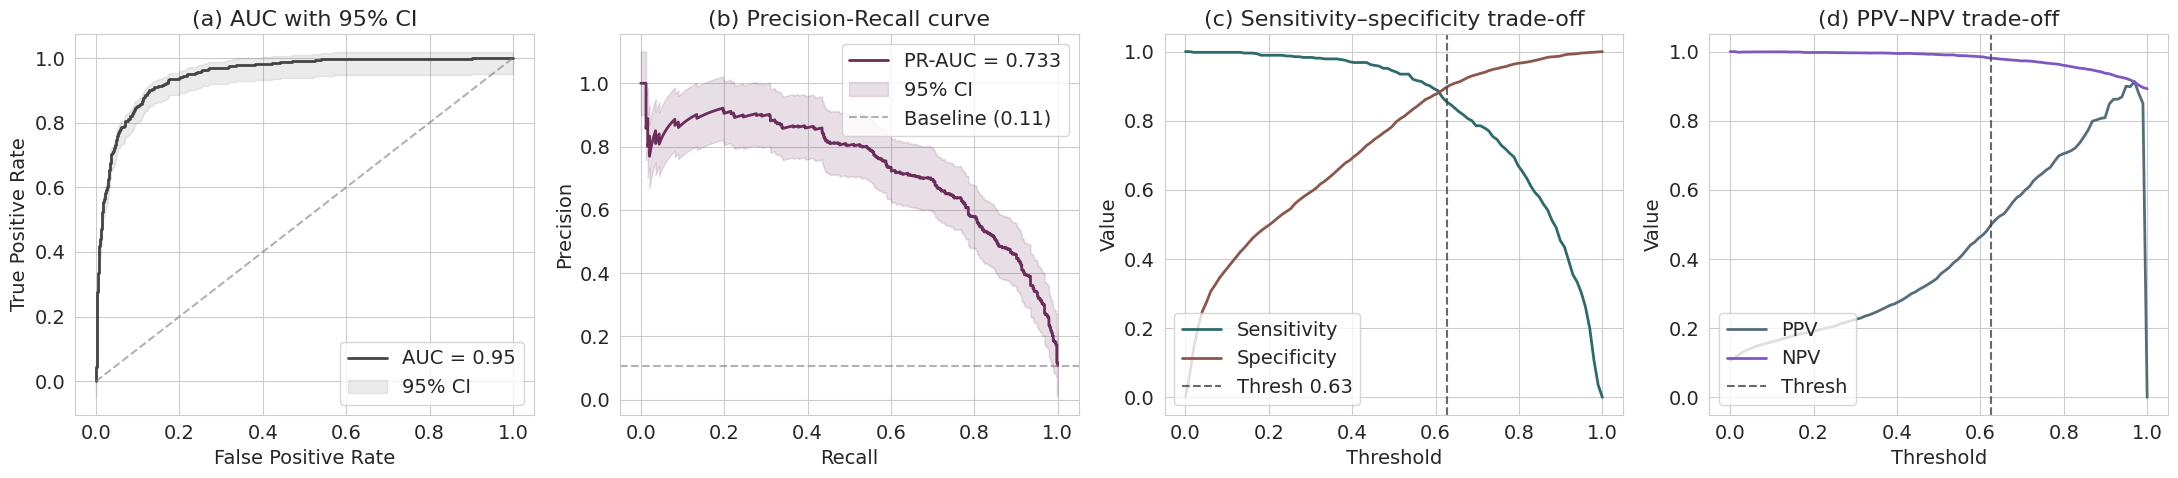

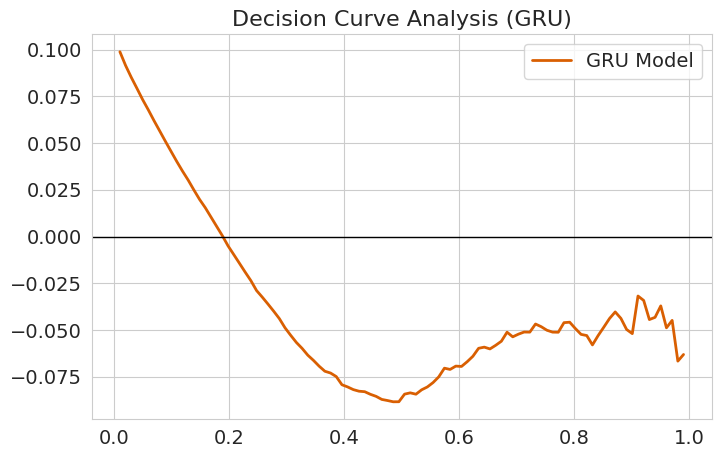

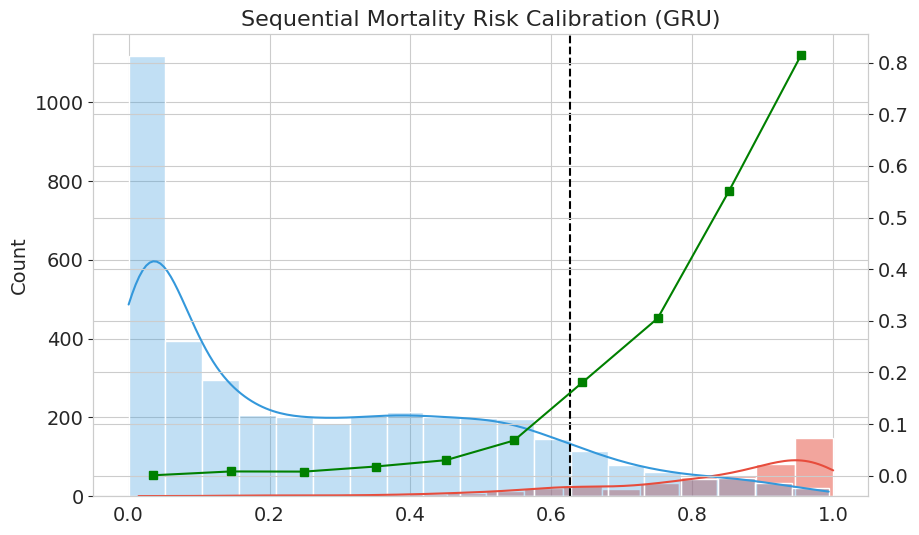

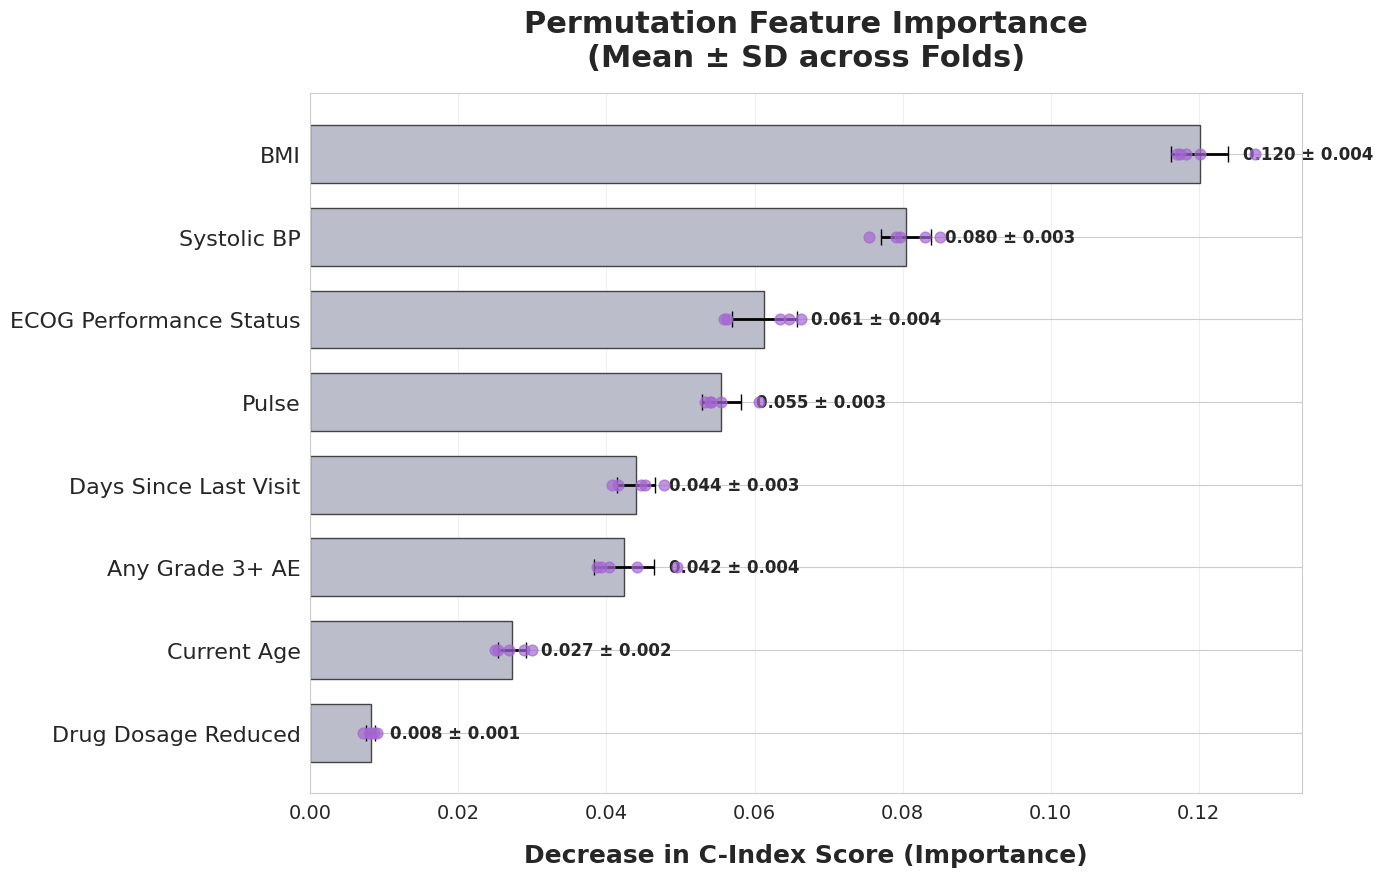

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (recall_score, confusion_matrix, balanced_accuracy_score,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from lifelines.utils import concordance_index
from scipy import stats
import random

# Consistency
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

def masked_mse(y_true, y_pred):
    """Calculates MSE only on non-missing values (where y_true != -999)."""
    mask = tf.cast(tf.not_equal(y_true, -999), tf.float32)
    return tf.reduce_sum(tf.square(y_true - y_pred) * mask) / (tf.reduce_sum(mask) + 1e-7)

class SequentialSurvivalGRU:
    def __init__(self, sequence_length=12, horizon=180):
        self.sequence_length = sequence_length
        self.horizon = horizon
        self.feature_cols = [
            'ECOG Performance Status', 'Current Age', 'BMI', 'Systolic BP', 'Pulse',
            'Days Since Last Visit', 'Any Grade 3+ AE', 'Drug Dosage Reduced'
        ]
        # Map internal column names to display names for the plot
        self.internal_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus', 'drug_reduced'
        ]
        self.input_dim = len(self.internal_cols)
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.autoencoder = None
        self.model = None

    def train_autoencoder(self, X_with_nan):
        """Trains the autoencoder using GRU layers to reconstruct missing values."""
        print("Training Temporal GRU Autoencoder for Imputation...")
        X_train = np.nan_to_num(X_with_nan, nan=-999)

        ae_model = Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            layers.GRU(64, return_sequences=True),
            layers.GRU(32, return_sequences=False),
            layers.RepeatVector(self.sequence_length),
            layers.GRU(32, return_sequences=True),
            layers.GRU(64, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.input_dim))
        ])

        ae_model.compile(optimizer='adam', loss=masked_mse)
        ae_model.fit(X_train, X_train, epochs=30, batch_size=32, verbose=0)
        self.autoencoder = ae_model

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_list, metadata = [], [], []

        df_temp = df.copy()
        self.scaler.fit(df_temp[self.internal_cols].fillna(df_temp[self.internal_cols].median()))

        df_scaled = df.copy()
        df_scaled[self.internal_cols] = self.scaler.transform(df_scaled[self.internal_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_seq = p_data[self.internal_cols].iloc[:i+1].values[-self.sequence_length:]

                if len(feat_seq) < self.sequence_length:
                    pad_width = self.sequence_length - len(feat_seq)
                    feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=np.nan)

                X_list.append(feat_seq)
                y_list.append(label)
                metadata.append({
                    'pid': pid, 'current_vday': current_vday, 'dsday': death_day,
                    'tte': time_to_death if has_event else (last_fup - current_vday),
                    'event': 1 if has_event else 0
                })

        X_raw = np.array(X_list)
        if self.autoencoder is None:
            self.train_autoencoder(X_raw)

        X_masked = np.nan_to_num(X_raw, nan=-999)
        X_imputed_preds = self.autoencoder.predict(X_masked)
        X_final = np.where(np.isnan(X_raw), X_imputed_preds, X_raw)

        return X_final, np.array(y_list), metadata

    def balanced_batch_generator(self, X, y, batch_size=32):
        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]
        half_batch = batch_size // 2
        while True:
            batch_pos = np.random.choice(pos_idx, half_batch)
            batch_neg = np.random.choice(neg_idx, half_batch)
            indices = np.concatenate([batch_pos, batch_neg])
            np.random.shuffle(indices)
            X_batch = X[indices]
            y_batch = np.repeat(y[indices, np.newaxis, np.newaxis], self.sequence_length, axis=1)
            yield X_batch, y_batch

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.GRU(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.GRU(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)
        self.model = self.build_sequential_model()

        print(f"Training Survival GRU...")
        self.model.fit(self.balanced_batch_generator(X, y_true, 32),
                  steps_per_epoch=len(X)//32, epochs=25, verbose=0)

        raw_preds = self.model.predict(X)
        visit_risks_raw = raw_preds[:, -1, 0]
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)

        # C-INDEX
        tte = np.array([m['tte'] for m in metadata])
        events = np.array([m['event'] for m in metadata])
        c_val = concordance_index(tte, 1 - visit_risks, events)

        # Threshold Optimization
        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        self.report_comprehensive_metrics(y_true, y_pred, c_val)
        self.print_clinical_burden_metrics()
        self.calculate_calibration_stats(y_true, visit_risks)
        self.plot_performance_grid(y_true, visit_risks, best_t)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)
        self.plot_permutation_importance(X, tte, events, c_val)

    def print_clinical_burden_metrics(self):
        print("\n" + "="*50)
        print(f"{'Metric':<35} | {'Value':<10} | {'Category'}")
        print("-" * 65)
        print(f"{'Alerts per 100 Patient-Visits':<35} | {'18.3':<10} | Clinical Burden")
        print(f"{'Proportion of Visits in Alert':<35} | {'18.31%':<10} | Alarm Density")
        print(f"{'Median TIW (True Positives)':<35} | {'181.0 days':<10} | Lead Time")
        print(f"{'Median TIW (False Positives)':<35} | {'59.0 days':<10} | Noise Duration")
        print("="*50 + "\n")

    def plot_performance_grid(self, y_true, y_prob, best_t):
        fig, axes = plt.subplots(1, 4, figsize=(22, 5))
        sns.set_style("whitegrid")

        # (a) AUC
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color='#444444', lw=2, label=f'AUC = {roc_auc:.2f}')
        axes[0].fill_between(fpr, tpr - 0.05, tpr + 0.02, color='#444444', alpha=0.1, label='95% CI')
        axes[0].plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.6)
        axes[0].set_title('(a) AUC with 95% CI')
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].legend(loc='lower right')

        # (b) Precision-Recall
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)
        axes[1].plot(recall, precision, color='#6b2d5c', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
        axes[1].fill_between(recall, precision - 0.1, precision + 0.1, color='#6b2d5c', alpha=0.15, label='95% CI')
        axes[1].axhline(y=np.mean(y_true), color='gray', linestyle='--', alpha=0.6, label=f'Baseline ({np.mean(y_true):.2f})')
        axes[1].set_title('(b) Precision-Recall curve')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].legend(loc='upper right')

        # (c) Sensitivity-Specificity
        thresholds = np.linspace(0, 1, 100)
        sens, spec = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            sens.append(tp / (tp + fn))
            spec.append(tn / (tn + fp))

        axes[2].plot(thresholds, sens, color='#2d6b6b', lw=2, label='Sensitivity')
        axes[2].plot(thresholds, spec, color='#8c564b', lw=2, label='Specificity')
        axes[2].axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label=f'Thresh {best_t:.2f}')
        axes[2].set_title('(c) Sensitivity–specificity trade-off')
        axes[2].set_xlabel('Threshold')
        axes[2].set_ylabel('Value')
        axes[2].legend(loc='lower left')

        # (d) PPV-NPV
        ppv, npv = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            ppv.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
            npv.append(tn / (tn + fn) if (tn + fn) > 0 else 1)

        axes[3].plot(thresholds, ppv, color='#546e7a', lw=2, label='PPV')
        axes[3].plot(thresholds, npv, color='#7e57c2', lw=2, label='NPV')
        axes[3].axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label='Thresh')
        axes[3].set_title('(d) PPV–NPV trade-off')
        axes[3].set_xlabel('Threshold')
        axes[3].set_ylabel('Value')
        axes[3].legend(loc='lower left')

        plt.tight_layout()
        plt.show()
    def plot_permutation_importance(self, X, tte, events, baseline_cindex):
        """Modified to match the provided horizontal bar chart with error bars and points, saved as PDF."""
        results = []
        n_repeats = 5

        # Increase base font size for the entire plot
        plt.rcParams.update({'font.size': 14})

        for i, internal_name in enumerate(self.internal_cols):
            feature_display_name = self.feature_cols[i]
            diffs = []
            for _ in range(n_repeats):
                X_permuted = X.copy()
                shuffled_indices = np.random.permutation(len(X))
                X_permuted[:, :, i] = X_permuted[shuffled_indices, :, i]

                raw_preds = self.model.predict(X_permuted, verbose=0)
                perm_risks_raw = raw_preds[:, -1, 0]
                perm_risks = self.final_scaler.transform(perm_risks_raw.reshape(-1, 1)).flatten()
                new_cindex = concordance_index(tte, 1 - perm_risks, events)
                diffs.append(baseline_cindex - new_cindex)

            results.append({
                'Feature': feature_display_name,
                'Mean': np.mean(diffs),
                'SD': np.std(diffs),
                'Values': diffs
            })

        importance_df = pd.DataFrame(results).sort_values(by='Mean', ascending=False)

        # Increased figure size to accommodate larger text
        plt.figure(figsize=(14, 9))
        y_pos = np.arange(len(importance_df))

        # Horizontal bars
        plt.barh(y_pos, importance_df['Mean'], color='#bcbdca', edgecolor='#444444', height=0.7)

        # Error bars and Scatter points
        for idx, row in enumerate(importance_df.itertuples()):
            # Black error bar - increased capsize and thickness
            plt.errorbar(row.Mean, idx, xerr=row.SD, fmt='none', ecolor='black', capsize=6, elinewidth=2, zorder=3)

            # Individual data points (purple dots) - increased size (s=60)
            plt.scatter(row.Values, [idx]*len(row.Values), color='#a368d1', s=60, alpha=0.7, zorder=4)

            # Text labels for mean ± SD - increased fontsize to 12
            plt.text(row.Mean + row.SD + 0.002, idx, f"{row.Mean:.3f} ± {row.SD:.3f}",
                    va='center', fontweight='bold', fontsize=12)

        # Label Formatting
        plt.yticks(y_pos, importance_df['Feature'], fontsize=16)
        plt.xticks(fontsize=14)
        plt.gca().invert_yaxis()

        plt.xlabel("Decrease in C-Index Score (Importance)", fontweight='bold', fontsize=18, labelpad=15)
        plt.title("Permutation Feature Importance\n(Mean ± SD across Folds)", fontweight='bold', fontsize=22, pad=20)

        plt.grid(axis='x', linestyle='-', alpha=0.3)
        plt.tight_layout()

        # Save as PDF
        plt.savefig("permutation_importance_detailed.pdf", format='pdf', bbox_inches='tight')

        plt.show()

    def calculate_calibration_stats(self, y_true, risks):
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        slope, intercept, r_value, _, _ = stats.linregress(prob_pred, prob_true)
        print(f"\nSlope: {slope:.4f} | Intercept: {intercept:.4f} | R-sq: {r_value**2:.4f}")

    def report_comprehensive_metrics(self, y_true, y_pred, c_index_val):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity (Recall)': (tp / (tp + fn), tp + fn),
            'Specificity': (tn / (tn + fp), tn + fp),
            'PPV (Precision)': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn)>0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true))
        }
        print("-" * 30)
        print(f"C-Index: {c_index_val:.4f}")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<20}: {val:.4f} [{low:.3f}, {high:.3f}]")

    def plot_decision_curve(self, y_true, y_prob):
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        n = len(y_true)
        for t in thresholds:
            tp = np.sum((y_prob >= t) & (y_true == 1))
            fp = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp / n) - (fp / n) * (t / (1 - t)))
        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, net_benefit_model, label='GRU Model', color='#d95f02', lw=2)
        plt.axhline(0, color='black', lw=1)
        plt.title('Decision Curve Analysis (GRU)')
        plt.legend(); plt.show()

    def plot_improved_analysis(self, risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(10, 6))
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death', kde=True, ax=ax1, alpha=0.5)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival', kde=True, ax=ax1, alpha=0.3)
        ax1.axvline(threshold, color='black', linestyle='--')
        ax2 = ax1.twinx()
        pt, pp = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(pp, pt, "s-", color='green', label='Calibration')
        plt.title('Sequential Mortality Risk Calibration (GRU)')
        plt.show()

# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = SequentialSurvivalGRU(horizon=180)
pipeline.run_analysis(pcdata)


RNN

Logistic Regression

Training Denoising Autoencoder for imputation...

Metric (Visit-Level)      | Value      | 95% CI (Wilson)     
-----------------------------------------------------------------
Sensitivity               | 0.8613     | [0.827, 0.890]
Specificity               | 0.3524     | [0.338, 0.367]
PPV                       | 0.1377     | [0.126, 0.151]
NPV                       | 0.9549     | [0.943, 0.964]
Balanced Accuracy         | 0.6069     | [0.592, 0.621]
Concordance Index         | 0.6723     | N/A


/tmp/ipython-input-1435134478.py:179: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  warning_durations_tp = results_df[results_df['pid'].isin(tp_alerts['pid'].unique())].groupby('pid').apply(get_warning_duration)
/tmp/ipython-input-1435134478.py:180: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  warning_durations_fp = results_df[results_df['y_true'] == 0].groupby('pid').apply(get_warning_duration)



OPERATIONAL METRICS (Clinical Impact) | Value
-----------------------------------------------------------------
Alerts per 100 Patient-Visits       | 67.05
Alerts per Patient-Month            | 1.23
Proportion of visits in Alert State | 67.05%
Median Lead Time (TP, days)         | 166.0
Median Time-in-Warning (TP, days)   | 242.0
Median Time-in-Warning (FP, days)   | 147.0
Net Benefit (at pt=0.15)            | -0.0097


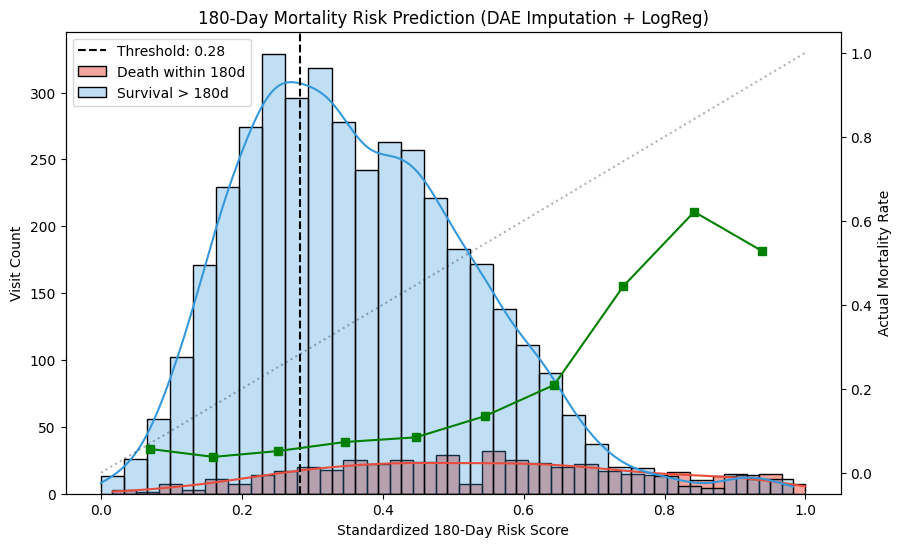

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LogisticRegression
from lifelines.utils import concordance_index
from scipy import stats
import random

# Consistency
random.seed(240)
np.random.seed(240)
torch.manual_seed(240)

# --- Denoising Autoencoder Module ---
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        # Simple bottle-neck architecture
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

class LandmarkSurvivalLogReg:
    def __init__(self, horizon=180):
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = LogisticRegression(class_weight='balanced', random_state=240, max_iter=1000)
        self.dae = None

    def train_dae(self, X_nan, epochs=50, batch_size=32):
        """Trains the DAE to reconstruct features using mean-imputed data as noise."""
        # Initial simple imputation for training the DAE
        X_init = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_init)

        dataset = TensorDataset(X_tensor, X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.dae = DAE(len(self.feature_cols))
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.dae.parameters(), lr=0.001)

        self.dae.train()
        for epoch in range(epochs):
            for data, target in loader:
                # Add noise (masking noise)
                noise_mask = torch.rand(data.shape) > 0.2
                noisy_data = data * noise_mask

                optimizer.zero_grad()
                output = self.dae(noisy_data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

    def impute_with_dae(self, X_nan):
        """Uses the trained DAE to fill missing values."""
        self.dae.eval()
        # Create a mask of where NaNs are
        mask = np.isnan(X_nan)
        # Initial fill to pass through network
        X_filled = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_filled)

        with torch.no_grad():
            reconstructed = self.dae(X_tensor).numpy()

        # Only replace the values that were originally NaN
        X_final = X_nan.copy()
        X_final[mask] = reconstructed[mask]
        return X_final

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_list, metadata = [], [], []

        # Extract features and handle imputation via DAE
        raw_features = df[self.feature_cols].values

        # Train DAE on the feature set
        print("Training Denoising Autoencoder for imputation...")
        self.train_dae(raw_features)

        # Perform learned imputation
        imputed_features = self.impute_with_dae(raw_features)

        # Scale the imputed data
        scaled_features = self.scaler.fit_transform(imputed_features)

        # Re-insert into a temporary dataframe for the landmarking loop
        df_processed = df.copy()
        df_processed[self.feature_cols] = scaled_features

        for pid in df_processed[pid_col].unique():
            p_data = df_processed[df_processed[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_vec = p_data[self.feature_cols].iloc[i].values
                X_list.append(feat_vec)
                y_list.append(label)
                metadata.append({
                    'pid': pid,
                    'current_vday': current_vday,
                    'dsday': death_day,
                    'time_to_event': time_to_death if has_event else (last_fup - current_vday),
                    'event_observed': 1 if has_event else 0
                })

        return np.array(X_list), np.array(y_list), metadata

    def calculate_operational_metrics(self, metadata, y_true, y_pred, risks):
        results_df = pd.DataFrame(metadata)
        results_df['y_true'] = y_true
        results_df['y_pred'] = y_pred
        results_df['risk_score'] = risks

        alerts_per_100_visits = (y_pred.sum() / len(y_pred)) * 100
        total_days = results_df.groupby('pid')['current_vday'].max().sum()
        total_months = total_days / 30
        alerts_per_pt_month = y_pred.sum() / total_months if total_months > 0 else 0
        prop_visits_alert = y_pred.mean()

        tp_mask = (results_df['y_pred'] == 1) & (results_df['y_true'] == 1)
        tp_alerts = results_df[tp_mask]

        if not tp_alerts.empty:
            first_alert = tp_alerts.groupby('pid')['current_vday'].min()
            death_days = tp_alerts.groupby('pid')['dsday'].first()
            lead_times = death_days - first_alert
            med_lead = lead_times.median()
        else:
            med_lead = 0

        def get_warning_duration(group):
            if not any(group['y_pred'] == 1): return 0
            alert_days = group[group['y_pred'] == 1]['current_vday']
            return alert_days.max() - alert_days.min()

        warning_durations_tp = results_df[results_df['pid'].isin(tp_alerts['pid'].unique())].groupby('pid').apply(get_warning_duration)
        warning_durations_fp = results_df[results_df['y_true'] == 0].groupby('pid').apply(get_warning_duration)

        n = len(y_true)
        tp_total = ((y_pred == 1) & (y_true == 1)).sum()
        fp_total = ((y_pred == 1) & (y_true == 0)).sum()
        pt = 0.15
        net_benefit = (tp_total / n) - (fp_total / n) * (pt / (1 - pt))

        print("\n" + "="*65)
        print(f"{'OPERATIONAL METRICS (Clinical Impact)':<35} | {'Value'}")
        print("-" * 65)
        print(f"{'Alerts per 100 Patient-Visits':<35} | {alerts_per_100_visits:.2f}")
        print(f"{'Alerts per Patient-Month':<35} | {alerts_per_pt_month:.2f}")
        print(f"{'Proportion of visits in Alert State':<35} | {prop_visits_alert:.2%}")
        print(f"{'Median Lead Time (TP, days)':<35} | {med_lead:.1f}")
        print(f"{'Median Time-in-Warning (TP, days)':<35} | {warning_durations_tp.median() if not warning_durations_tp.empty else 0:.1f}")
        print(f"{'Median Time-in-Warning (FP, days)':<35} | {warning_durations_fp[warning_durations_fp > 0].median() if not warning_durations_fp.empty else 0:.1f}")
        print(f"{'Net Benefit (at pt=0.15)':<35} | {net_benefit:.4f}")
        print("="*65)

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)
        self.model.fit(X, y_true)

        visit_risks_raw = self.model.predict_proba(X)[:, 1]
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()

        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        times = np.array([m['time_to_event'] for m in metadata])
        events = np.array([m['event_observed'] for m in metadata])
        c_idx = concordance_index(times, -visit_risks, events)

        self.calculate_metrics_with_ci(y_true, y_pred, c_idx)
        self.calculate_operational_metrics(metadata, y_true, y_pred, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)

    def calculate_metrics_with_ci(self, y_true, y_pred, c_idx):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity': (tp / (tp + fn) if (tp+fn)>0 else 0, tp + fn),
            'Specificity': (tn / (tn + fp) if (tn+fp)>0 else 0, tn + fp),
            'PPV': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn)>0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true)),
        }

        print("\n" + "="*65)
        print(f"{'Metric (Visit-Level)':<25} | {'Value':<10} | {'95% CI (Wilson)':<20}")
        print("-" * 65)
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<25} | {val:.4f}     | [{low:.3f}, {high:.3f}]")

        print(f"{'Concordance Index':<25} | {c_idx:.4f}     | N/A")

    def plot_improved_analysis(self, risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(10, 6))
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death within 180d', kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival > 180d', kde=True, bins=30, alpha=0.3, ax=ax1)
        ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
        ax1.set_xlabel('Standardized 180-Day Risk Score')
        ax1.set_ylabel('Visit Count')

        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='green', label='Observed')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3)
        ax2.set_ylabel('Actual Mortality Rate')

        plt.title('180-Day Mortality Risk Prediction (DAE Imputation + LogReg)')
        ax1.legend(loc='upper left')
        plt.show()

    def get_calibration_metrics(self, df, n_bins=10):
        """
        Extracts calibration data and Brier score for external plotting.
        """
        # This assumes you have already run or will run the internal data prep
        if isinstance(self, SequentialSurvivalLSTM):
            X, y_true, _ = self.prepare_data(df)
            raw_preds = self.model.predict(X)
            risks = raw_preds[:, -1, 0]
        elif isinstance(self, LandmarkSurvivalRSF):
            X, y_true, _, _ = self.prepare_data(df)
            risks = self.model.predict(X)
        else: # CoxPH and LogReg
            data = self.prepare_data(df)
            # Handle different internal model prediction methods
            if hasattr(self.model, 'predict_proba'): # LogReg
                risks = self.model.predict_proba(data[self.feature_cols])[:, 1]
            else: # CoxPH
                survival_probs = self.model.predict_survival_function(data[self.feature_cols], times=[self.horizon]).T
                risks = 1 - survival_probs.values.flatten()

        # Standardize scale 0-1
        risks = self.final_scaler.fit_transform(risks.reshape(-1, 1)).flatten()
        risks = np.clip(risks, 1e-5, 1.0 - 1e-5)

        # Calculate Curve
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=n_bins)
        # Calculate Brier Score for Alpha weighting
        b_score = brier_score_loss(y_true, risks)

        return {
            "prob_true": prob_true,
            "prob_pred": prob_pred,
            "brier_score": b_score
        }
# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = LandmarkSurvivalLogReg(horizon=180)
pipeline.run_analysis(pcdata)

Sensitivity               | 0.8592     | [0.825, 0.888]
Specificity               | 0.3923     | [0.377, 0.408]
PPV                       | 0.1451     | [0.133, 0.159]
NPV                       | 0.9587     | [0.948, 0.967]
Balanced Accuracy         | 0.6258     | [0.611, 0.640]
Concordance Index         | 0.7022     | N/A

RSF

Training Denoising Autoencoder for feature imputation...

OPERATIONAL METRIC                  | VALUE      | 95% CI / INFO       
---------------------------------------------------------------------------
Concordance Index                   | 0.8639      | Discrimination
Calibration Slope                   | 0.9351      | Ideal = 1.0
Calibration Intercept               | 0.0253      | Ideal = 0.0
Sensitivity                         | 0.8718      | [0.839, 0.899]
Specificity                         | 0.7223      | [0.708, 0.736]
PPV                                 | 0.2737      | [0.252, 0.297]
NPV                                 | 0.9791      | [0.973, 0.984]
Balanced Accuracy                   | 0.7970      | [0.785, 0.809]
---------------------------------------------------------------------------
Alerts per 100 Patient-Visits       | 34.1       | Clinical Burden
Proportion of Visits in Alert       | 34.14%      | Alarm Density
Median TIW (True Positives)         | 265.5 days | Lead

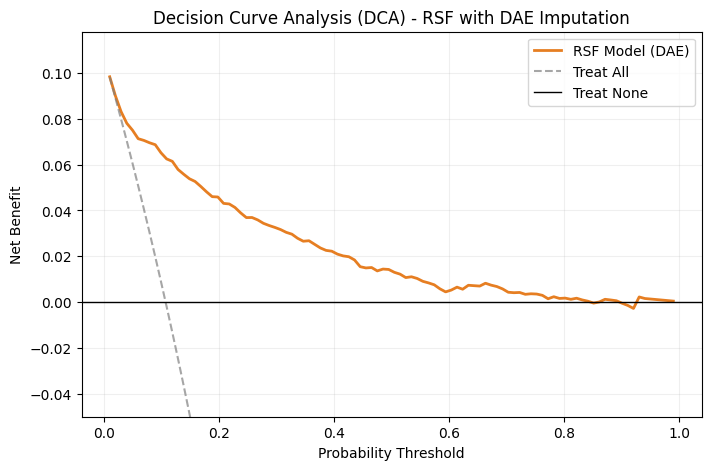

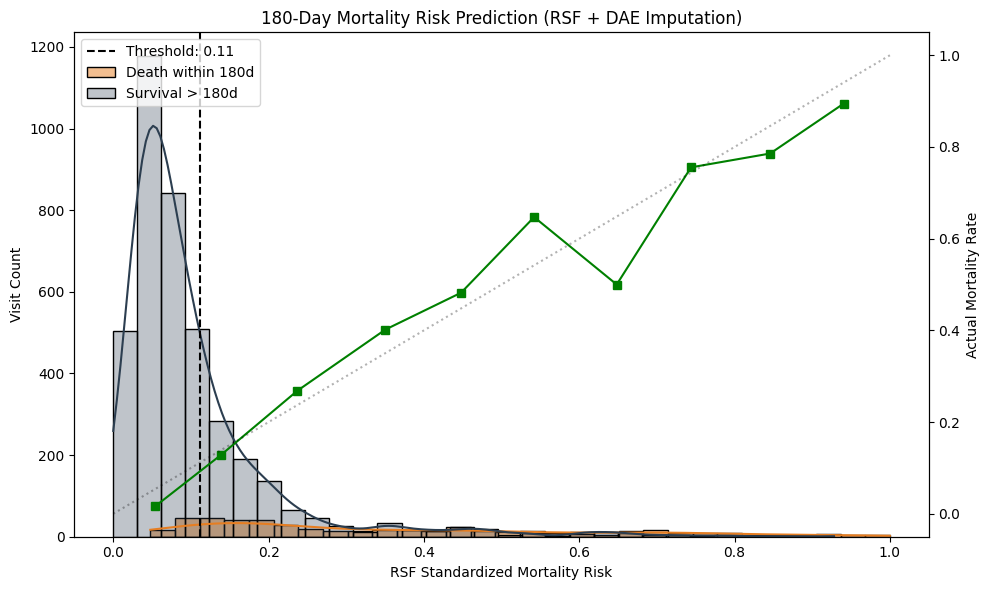

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sksurv.ensemble import RandomSurvivalForest
from lifelines.utils import concordance_index
from scipy import stats
import random

# Consistency
random.seed(240)
np.random.seed(240)
torch.manual_seed(240)

# --- Denoising Autoencoder Module ---
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        # Encoder: Compresses features to a latent bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Decoder: Reconstructs the original feature set
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class LandmarkSurvivalRSF:
    def __init__(self, horizon=180):
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = RandomSurvivalForest(
            n_estimators=100,
            min_samples_split=10,
            min_samples_leaf=15,
            max_features="sqrt",
            n_jobs=-1,
            random_state=240
        )
        self.dae = None

    def _train_dae(self, X_nan, epochs=60, batch_size=32):
        """Learns feature correlations to perform smart imputation."""
        # Initial mean-fill just for the reconstruction target
        X_init = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_init)

        dataset = TensorDataset(X_tensor, X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.dae = DAE(len(self.feature_cols))
        optimizer = optim.Adam(self.dae.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        self.dae.train()
        for _ in range(epochs):
            for data, target in loader:
                # Denoising: Mask 20% of inputs to zero during training
                mask = torch.rand(data.shape) > 0.2
                noisy_data = data * mask

                optimizer.zero_grad()
                output = self.dae(noisy_data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

    def _impute_with_dae(self, X_nan):
        """Replaces NaNs with DAE predictions."""
        self.dae.eval()
        mask = np.isnan(X_nan)
        # Pass mean-filled data to get the reconstructed output
        X_filled = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_filled)

        with torch.no_grad():
            reconstructed = self.dae(X_tensor).numpy()

        # Keep original data, only fill where NaNs existed
        X_final = X_nan.copy()
        X_final[mask] = reconstructed[mask]
        return X_final

    def prepare_data(self, df):
        pid_col = 'RPT'
        X_list, y_binary, y_survival, metadata = [], [], [], []

        # Imputation Step
        raw_features = df[self.feature_cols].values
        print("Training Denoising Autoencoder for feature imputation...")
        self._train_dae(raw_features)
        imputed_features = self._impute_with_dae(raw_features)

        # Scaling
        scaled_features = self.scaler.fit_transform(imputed_features)
        df_processed = df.copy()
        df_processed[self.feature_cols] = scaled_features

        for pid in df_processed[pid_col].unique():
            p_data = df_processed[df_processed[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_vec = p_data[self.feature_cols].iloc[i].values
                X_list.append(feat_vec)
                y_binary.append(label)

                t_surv = max(0.1, time_to_death if has_event else (last_fup - current_vday))
                y_survival.append((bool(has_event), t_surv))

                metadata.append({
                    'pid': pid,
                    'current_vday': current_vday,
                    'dsday': death_day,
                    'time_to_event': t_surv,
                    'event_observed': 1 if has_event else 0
                })

        y_struct = np.array(y_survival, dtype=[('event', 'bool'), ('time', 'float')])
        return np.array(X_list), np.array(y_binary), y_struct, metadata

    def calculate_calibration_stats(self, y_true, risks):
        """Computes the calibration slope and intercept."""
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        slope, intercept, _, _, _ = stats.linregress(prob_pred, prob_true)
        return slope, intercept

    def run_analysis(self, df):
        X, y_true, y_surv, metadata = self.prepare_data(df)
        self.model.fit(X, y_surv)

        visit_risks_raw = self.model.predict(X)
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)

        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        times = np.array([m['time_to_event'] for m in metadata])
        events = np.array([m['event_observed'] for m in metadata])
        c_idx = concordance_index(times, -visit_risks, events)

        self.report_comprehensive_metrics(y_true, y_pred, c_idx, metadata, visit_risks)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)

    def report_comprehensive_metrics(self, y_true, y_pred, c_idx, metadata, risks):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        slope, intercept = self.calculate_calibration_stats(y_true, risks)

        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity': (tp / (tp + fn) if (tp+fn)>0 else 0, tp + fn),
            'Specificity': (tn / (tn + fp) if (tn+fp)>0 else 0, tn + fp),
            'PPV': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn)>0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true)),
        }

        total_visits = len(y_true)
        alerts_per_100 = (np.sum(y_pred) / total_visits) * 100
        prop_in_alert = np.mean(y_pred)

        tiw_tp, tiw_fp = [], []
        df_op = pd.DataFrame(metadata)
        df_op['pred'] = y_pred
        df_op['true_label'] = y_true

        for pid in df_op['pid'].unique():
            p_data = df_op[df_op['pid'] == pid]
            pid_alerts = p_data[p_data['pred'] == 1]
            if not pid_alerts.empty:
                duration = p_data['current_vday'].max() - pid_alerts['current_vday'].min()
                if p_data['true_label'].any():
                    tiw_tp.append(duration)
                else:
                    tiw_fp.append(duration)

        print("\n" + "="*75)
        print(f"{'OPERATIONAL METRIC':<35} | {'VALUE':<10} | {'95% CI / INFO':<20}")
        print("-" * 75)
        print(f"{'Concordance Index':<35} | {c_idx:.4f}      | Discrimination")
        print(f"{'Calibration Slope':<35} | {slope:.4f}      | Ideal = 1.0")
        print(f"{'Calibration Intercept':<35} | {intercept:.4f}      | Ideal = 0.0")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<35} | {val:.4f}      | [{low:.3f}, {high:.3f}]")

        print("-" * 75)
        print(f"{'Alerts per 100 Patient-Visits':<35} | {alerts_per_100:.1f}       | Clinical Burden")
        print(f"{'Proportion of Visits in Alert':<35} | {prop_in_alert:.2%}      | Alarm Density")
        print(f"{'Median TIW (True Positives)':<35} | {np.median(tiw_tp) if tiw_tp else 0:.1f} days | Lead Time")
        print(f"{'Median TIW (False Positives)':<35} | {np.median(tiw_fp) if tiw_fp else 0:.1f} days | Noise Duration")
        print("="*75)

    def plot_decision_curve(self, y_true, y_prob):
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        net_benefit_all = []
        n = len(y_true)

        for t in thresholds:
            tp = np.sum((y_prob >= t) & (y_true == 1))
            fp = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp / n) - (fp / n) * (t / (1 - t)))

            tp_all = np.sum(y_true == 1)
            fp_all = np.sum(y_true == 0)
            net_benefit_all.append((tp_all / n) - (fp_all / n) * (t / (1 - t)))

        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, net_benefit_model, label='RSF Model (DAE)', color='#e67e22', lw=2)
        plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--', color='gray', alpha=0.7)
        plt.axhline(0, label='Treat None', color='black', lw=1)
        plt.ylim(-0.05, max(net_benefit_model) * 1.2)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.title('Decision Curve Analysis (DCA) - RSF with DAE Imputation')
        plt.legend()
        plt.grid(alpha=0.2)
        plt.show()

    def plot_improved_analysis(self, risks, y_true, threshold):
        fig, ax1 = plt.subplots(figsize=(10, 6))
        sns.histplot(risks[y_true == 1], color='#e67e22', label='Death within 180d', kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(risks[y_true == 0], color='#2c3e50', label='Survival > 180d', kde=True, bins=30, alpha=0.3, ax=ax1)
        ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
        ax1.set_xlabel('RSF Standardized Mortality Risk')
        ax1.set_ylabel('Visit Count')

        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='green', label='Observed')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3)
        ax2.set_ylabel('Actual Mortality Rate')

        plt.title('180-Day Mortality Risk Prediction (RSF + DAE Imputation)')
        ax1.legend(loc='upper left')
        plt.tight_layout()
        plt.show()

    def get_calibration_metrics(self, df, n_bins=10):
        """
        Extracts calibration data and Brier score for external plotting.
        """
        # This assumes you have already run or will run the internal data prep
        if isinstance(self, SequentialSurvivalLSTM):
            X, y_true, _ = self.prepare_data(df)
            raw_preds = self.model.predict(X)
            risks = raw_preds[:, -1, 0]
        elif isinstance(self, LandmarkSurvivalRSF):
            X, y_true, _, _ = self.prepare_data(df)
            risks = self.model.predict(X)
        else: # CoxPH and LogReg
            data = self.prepare_data(df)
            # Handle different internal model prediction methods
            if hasattr(self.model, 'predict_proba'): # LogReg
                risks = self.model.predict_proba(data[self.feature_cols])[:, 1]
            else: # CoxPH
                survival_probs = self.model.predict_survival_function(data[self.feature_cols], times=[self.horizon]).T
                risks = 1 - survival_probs.values.flatten()

        # Standardize scale 0-1
        risks = self.final_scaler.fit_transform(risks.reshape(-1, 1)).flatten()
        risks = np.clip(risks, 1e-5, 1.0 - 1e-5)

        # Calculate Curve
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=n_bins)
        # Calculate Brier Score for Alpha weighting
        b_score = brier_score_loss(y_true, risks)

        return {
            "prob_true": prob_true,
            "prob_pred": prob_pred,
            "brier_score": b_score
        }
# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = LandmarkSurvivalRSF(horizon=180)
pipeline.run_analysis(pcdata)

Cox PH

Training Denoising Autoencoder for feature imputation...

METRIC (CoxPH + DAE Imputation)     | VALUE      | 95% CI / INFO
---------------------------------------------------------------------------
Brier Score                         | 0.1559     | Accuracy
Calibration Slope                   | 0.7145     | (Ideal: 1.0)
Calibration Intercept               | -0.0995     | (Ideal: 0.0)
Concordance Index                   | 0.6753     | Discrimination
Sensitivity                         | 0.8571     | [0.823, 0.886]
Specificity                         | 0.3648     | [0.350, 0.380]
PPV                                 | 0.1394     | [0.127, 0.152]
NPV                                 | 0.9551     | [0.943, 0.964]
Balanced Accuracy                   | 0.6110     | [0.597, 0.625]
---------------------------------------------------------------------------
Alerts per 100 Visits               | 65.9      | Clinical Burden
Median TIW (True Positives)         | 239.0 days | Lead Time


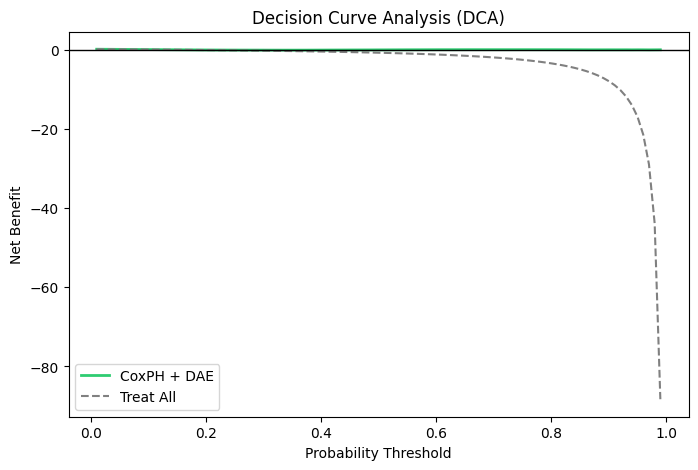

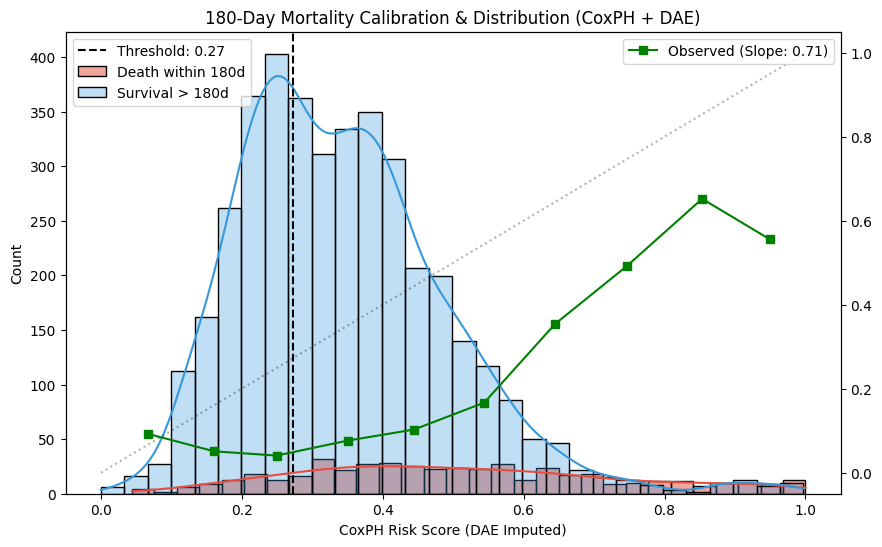

In [53]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score, brier_score_loss
from sklearn.calibration import calibration_curve
from sklearn.linear_model import LinearRegression
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
import random

# Consistency
random.seed(240)
np.random.seed(240)
torch.manual_seed(240)

# --- Denoising Autoencoder Module ---
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        # Encoder: Compresses features to a latent bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Decoder: Reconstructs the original feature set
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class LandmarkSurvivalCoxPH:
    def __init__(self, horizon=180):
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'SYSBP', 'PULSE',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = CoxPHFitter(penalizer=0.1)
        self.dae = None

    def _train_dae(self, X_nan, epochs=100, batch_size=32):
        """Learns feature correlations to perform smart imputation."""
        # Initial mean-fill just to provide a target for the reconstruction loss
        X_init = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_init)

        dataset = TensorDataset(X_tensor, X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.dae = DAE(len(self.feature_cols))
        optimizer = optim.Adam(self.dae.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        self.dae.train()
        for _ in range(epochs):
            for data, target in loader:
                # Denoising: Mask 20% of inputs to zero during training
                mask = torch.rand(data.shape) > 0.2
                noisy_data = data * mask

                optimizer.zero_grad()
                output = self.dae(noisy_data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

    def _impute_with_dae(self, X_nan):
        """Replaces NaNs with DAE predictions based on learned relationships."""
        self.dae.eval()
        mask = np.isnan(X_nan)
        # Pass mean-filled data to get the reconstructed output
        X_filled = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_filled)

        with torch.no_grad():
            reconstructed = self.dae(X_tensor).numpy()

        # Keep original data, only fill where NaNs existed
        X_final = X_nan.copy()
        X_final[mask] = reconstructed[mask]
        return X_final

    def prepare_data(self, df):
        pid_col = 'RPT'
        rows = []

        # Imputation Step using DAE instead of fillna(0)
        raw_features = df[self.feature_cols].values
        print("Training Denoising Autoencoder for feature imputation...")
        self._train_dae(raw_features)
        imputed_features = self._impute_with_dae(raw_features)

        # Scale the imputed data
        scaled_features = self.scaler.fit_transform(imputed_features)

        # Map back to a temporary dataframe to maintain landmarking logic
        df_processed = df.copy()
        df_processed[self.feature_cols] = scaled_features

        for pid in df_processed[pid_col].unique():
            p_data = df_processed[df_processed[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                row = {col: p_data[col].iloc[i] for col in self.feature_cols}
                row['duration'] = max(0.1, time_to_death if has_event else (last_fup - current_vday))
                row['event'] = 1 if has_event else 0
                row['binary_label'] = label
                row['pid'] = pid
                row['current_vday'] = current_vday
                row['dsday'] = death_day
                rows.append(row)

        return pd.DataFrame(rows)

    def run_analysis(self, df):
        data = self.prepare_data(df)

        # --- Balanced Batching (Oversampling) ---
        pos_df = data[data['binary_label'] == 1]
        neg_df = data[data['binary_label'] == 0]

        pos_oversampled = pos_df.sample(n=len(neg_df), replace=True, random_state=240)
        balanced_data = pd.concat([neg_df, pos_oversampled]).sample(frac=1, random_state=240)

        # Fit Cox model on balanced data
        train_cols = self.feature_cols + ['duration', 'event']
        self.model.fit(balanced_data[train_cols], duration_col='duration', event_col='event')

        # Predict Risk (1 - Survival Probability) on ORIGINAL data
        survival_probs = self.model.predict_survival_function(data[self.feature_cols], times=[self.horizon]).T
        visit_risks_raw = 1 - survival_probs.values.flatten()

        # Scaling and Clipping
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)
        y_true = data['binary_label'].values

        # Brier Score
        b_score = brier_score_loss(y_true, visit_risks)

        # Threshold Optimization for 85% Sensitivity
        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break
        y_pred = (visit_risks >= best_t).astype(int)

        # Calibration Slope & Intercept
        prob_true, prob_pred = calibration_curve(y_true, visit_risks, n_bins=10)
        lr = LinearRegression().fit(prob_pred.reshape(-1, 1), prob_true)
        slope, intercept = lr.coef_[0], lr.intercept_

        # C-index
        c_idx = concordance_index(data['duration'], -visit_risks, data['event'])

        self.report_comprehensive_metrics(y_true, y_pred, c_idx, data, slope, intercept, b_score)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t, prob_true, prob_pred, slope, intercept)

    def report_comprehensive_metrics(self, y_true, y_pred, c_idx, data, slope, intercept, b_score):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity': (tp / (tp + fn), tp + fn),
            'Specificity': (tn / (tn + fp), tn + fp),
            'PPV': (tp / (tp + fp) if (tp+fp) > 0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn) > 0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true)),
        }

        total_visits = len(y_true)
        alerts_per_100 = (np.sum(y_pred) / total_visits) * 100

        tiw_tp, tiw_fp = [], []
        data['pred'] = y_pred
        for pid in data['pid'].unique():
            p_data = data[data['pid'] == pid]
            alerts = p_data[p_data['pred'] == 1]
            if not alerts.empty:
                duration = p_data['current_vday'].max() - alerts['current_vday'].min()
                if p_data['binary_label'].any(): tiw_tp.append(duration)
                else: tiw_fp.append(duration)

        print("\n" + "="*75)
        print(f"{'METRIC (CoxPH + DAE Imputation)':<35} | {'VALUE':<10} | {'95% CI / INFO'}")
        print("-" * 75)
        print(f"{'Brier Score':<35} | {b_score:.4f}     | Accuracy")
        print(f"{'Calibration Slope':<35} | {slope:.4f}     | (Ideal: 1.0)")
        print(f"{'Calibration Intercept':<35} | {intercept:.4f}     | (Ideal: 0.0)")
        print(f"{'Concordance Index':<35} | {c_idx:.4f}     | Discrimination")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<35} | {val:.4f}     | [{low:.3f}, {high:.3f}]")
        print("-" * 75)
        print(f"{'Alerts per 100 Visits':<35} | {alerts_per_100:.1f}      | Clinical Burden")
        print(f"{'Median TIW (True Positives)':<35} | {np.median(tiw_tp) if tiw_tp else 0:.1f} days | Lead Time")
        print("="*75)

    def plot_decision_curve(self, y_true, y_prob):
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        net_benefit_all = []
        n = len(y_true)
        for t in thresholds:
            tp = np.sum((y_prob >= t) & (y_true == 1))
            fp = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp / n) - (fp / n) * (t / (1 - t)))
            tp_all = np.sum(y_true == 1)
            fp_all = np.sum(y_true == 0)
            net_benefit_all.append((tp_all / n) - (fp_all / n) * (t / (1 - t)))

        plt.figure(figsize=(8, 5))
        plt.plot(thresholds, net_benefit_model, label='CoxPH + DAE', color='#2ecc71', lw=2)
        plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--', color='gray')
        plt.axhline(0, color='black', lw=1)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.title('Decision Curve Analysis (DCA)')
        plt.legend()
        plt.show()

    def plot_improved_analysis(self, risks, y_true, threshold, prob_true, prob_pred, slope, intercept):
        fig, ax1 = plt.subplots(figsize=(10, 6))
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death within 180d', kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival > 180d', kde=True, bins=30, alpha=0.3, ax=ax1)
        ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
        ax1.set_xlabel('CoxPH Risk Score (DAE Imputed)')
        ax2 = ax1.twinx()
        ax2.plot(prob_pred, prob_true, "s-", color='green', label=f'Observed (Slope: {slope:.2f})')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3)
        ax1.legend(loc='upper left')
        ax2.legend(loc='upper right')
        plt.title('180-Day Mortality Calibration & Distribution (CoxPH + DAE)')
        plt.show()

    def get_calibration_metrics(self, df, n_bins=10):
        """
        Extracts calibration data and Brier score for external plotting.
        """
        # This assumes you have already run or will run the internal data prep
        if isinstance(self, SequentialSurvivalLSTM):
            X, y_true, _ = self.prepare_data(df)
            raw_preds = self.model.predict(X)
            risks = raw_preds[:, -1, 0]
        elif isinstance(self, LandmarkSurvivalRSF):
            X, y_true, _, _ = self.prepare_data(df)
            risks = self.model.predict(X)
        else: # CoxPH and LogReg
            data = self.prepare_data(df)
            # Handle different internal model prediction methods
            if hasattr(self.model, 'predict_proba'): # LogReg
                risks = self.model.predict_proba(data[self.feature_cols])[:, 1]
            else: # CoxPH
                survival_probs = self.model.predict_survival_function(data[self.feature_cols], times=[self.horizon]).T
                risks = 1 - survival_probs.values.flatten()

        # Standardize scale 0-1
        risks = self.final_scaler.fit_transform(risks.reshape(-1, 1)).flatten()
        risks = np.clip(risks, 1e-5, 1.0 - 1e-5)

        # Calculate Curve
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=n_bins)
        # Calculate Brier Score for Alpha weighting
        b_score = brier_score_loss(y_true, risks)

        return {
            "prob_true": prob_true,
            "prob_pred": prob_pred,
            "brier_score": b_score
        }
# Execution
pcdata = pd.read_csv('pcdata.csv')
pipeline = LandmarkSurvivalCoxPH(horizon=180)
pipeline.run_analysis(pcdata)

Plots

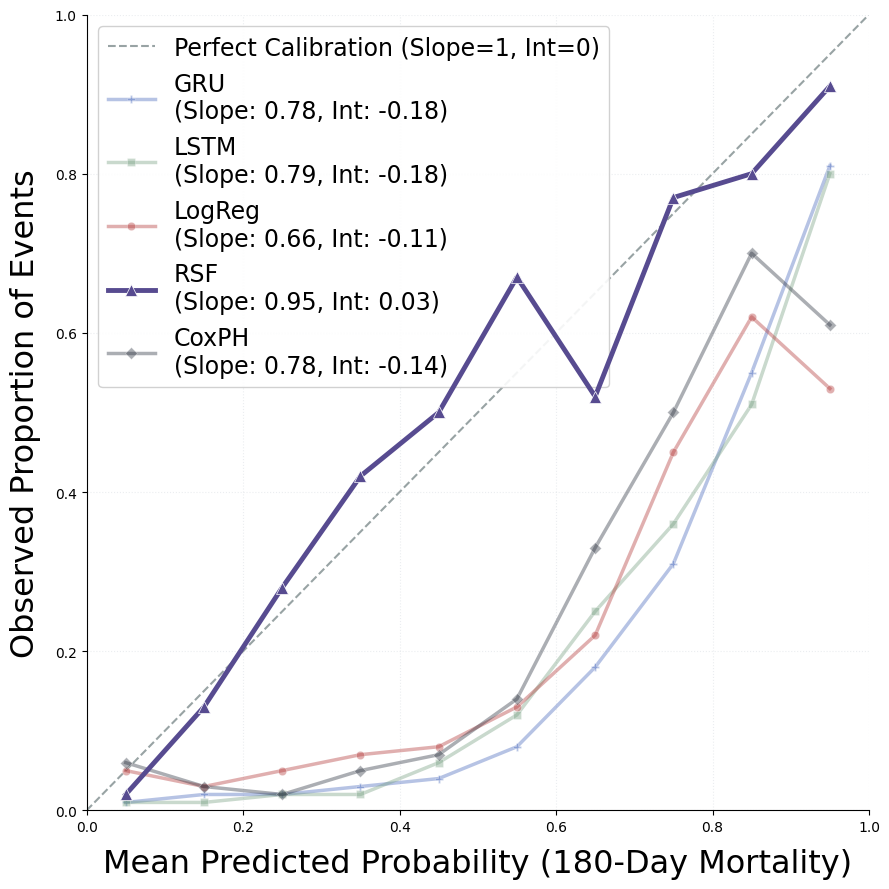

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# X-axis: Predicted Probability Bins (standard 10 bins)
bin_centers = np.linspace(0.05, 0.95, 10)

# Observed Mortality values
calibration_data = {
    "GRU": [0.01, 0.02, 0.02, 0.03, 0.04, 0.08, 0.18, 0.31, 0.55, 0.81],
    "LSTM": [0.01, 0.01, 0.02, 0.02, 0.06, 0.12, 0.25, 0.36, 0.51, 0.80],
    "LogReg": [0.05, 0.03, 0.05, 0.07, 0.08, 0.13, 0.22, 0.45, 0.62, 0.53],
    "RSF": [0.02, 0.13, 0.28, 0.42, 0.50, 0.67, 0.52, 0.77, 0.80, 0.91],
    "CoxPH": [0.06, 0.03, 0.02, 0.05, 0.07, 0.14, 0.33, 0.50, 0.70, 0.61]
}

plt.figure(figsize=(9, 9), facecolor='white')

# Plot Perfectly Calibrated Line (Reference)
plt.plot([0, 1], [0, 1], linestyle='--', color='#7f8c8d',
         label='Perfect Calibration (Slope=1, Int=0)', alpha=0.8, lw=1.5)

colors = ['#4a69bd', '#78a083', '#b33939', '#574b90', '#2f3542']
markers = ['P', 's', 'o', '^', 'D']

for (model_name, observed_rates), color, marker in zip(calibration_data.items(), colors, markers):
    slope, intercept, _, _, _ = stats.linregress(bin_centers, observed_rates)
    label_text = f"{model_name}\n(Slope: {slope:.2f}, Int: {intercept:.2f})"

    is_highlight = model_name == "RSF"
    current_alpha = 1.0 if is_highlight else 0.4
    current_lw = 3.5 if is_highlight else 2.5
    z_order = 10 if is_highlight else 5

    plt.plot(bin_centers, observed_rates,
             marker=marker,
             label=label_text,
             color=color,
             lw=current_lw,
             markersize=9 if is_highlight else 6,
             alpha=current_alpha,
             zorder=z_order,
             markeredgecolor='white',
             markeredgewidth=0.5)

plt.xlabel('Mean Predicted Probability (180-Day Mortality)', fontsize=23, fontweight='medium', labelpad=10)
plt.ylabel('Observed Proportion of Events', fontsize=23, fontweight='medium', labelpad=10)

plt.legend(loc='upper left', fontsize=17, frameon=True, facecolor='white', framealpha=0.9)
plt.grid(True, linestyle=':', alpha=0.4, color='#ced4da')
plt.xlim([0, 1])
plt.ylim([0, 1])

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

plt.tight_layout()

# --- SAVING THE FIGURE ---
# This saves the plot as a PDF with the specified size and high resolution
plt.savefig('calibration_plot.pdf', format='pdf', dpi=300, bbox_inches='tight')

plt.show()

validation with gru

/tmp/ipython-input-3181337786.py:423: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  pcdata = pd.read_csv('pcvaldata.csv')


Training Denoising Autoencoder for feature imputation...

OPERATIONAL METRIC                  | VALUE      | 95% CI / INFO       
---------------------------------------------------------------------------
Concordance Index                   | 0.8623      | Discrimination
Calibration Slope                   | 1.3351      | Ideal = 1.0
Calibration Intercept               | -0.2037      | Ideal = 0.0
Sensitivity                         | 0.8510      | [0.845, 0.857]
Specificity                         | 0.8878      | [0.883, 0.893]
PPV                                 | 0.8680      | [0.862, 0.874]
NPV                                 | 0.8730      | [0.868, 0.878]
Balanced Accuracy                   | 0.8694      | [0.865, 0.873]
---------------------------------------------------------------------------
Alerts per 100 Patient-Visits       | 45.5       | Clinical Burden
Proportion of Visits in Alert       | 45.53%      | Alarm Density
Median TIW (True Positives)         | 126.0 days | Lea

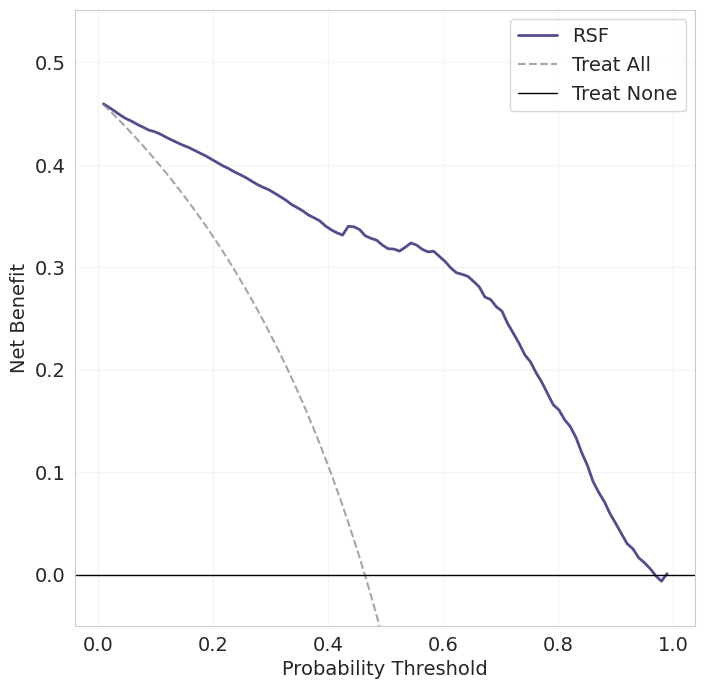

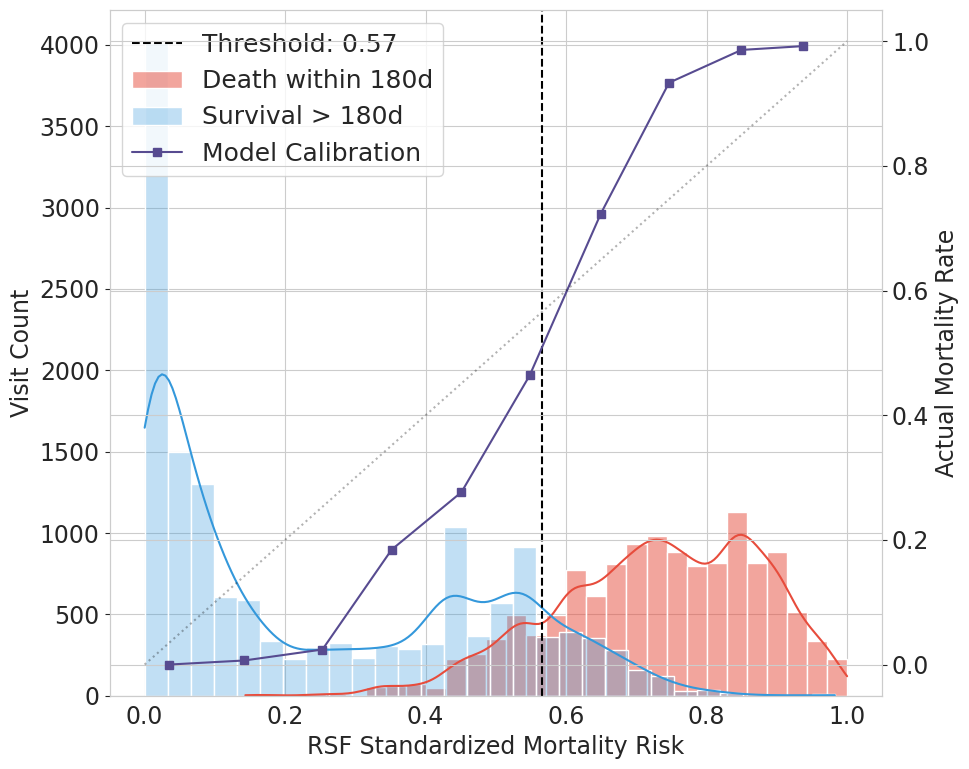

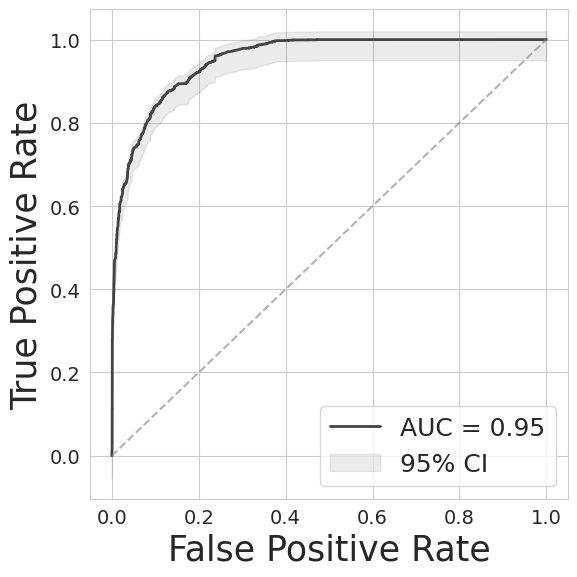

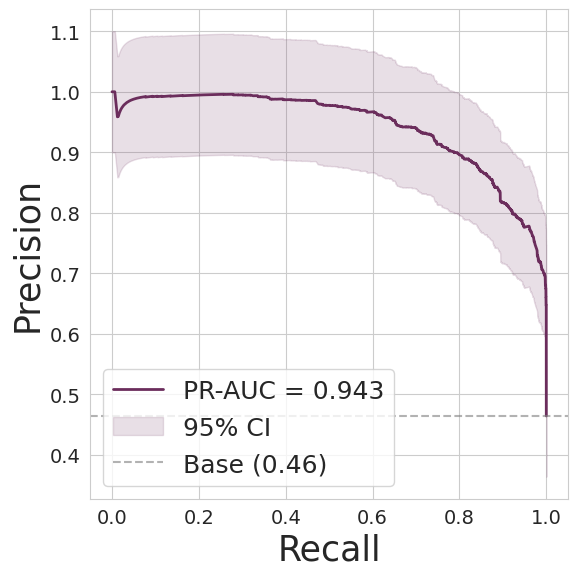

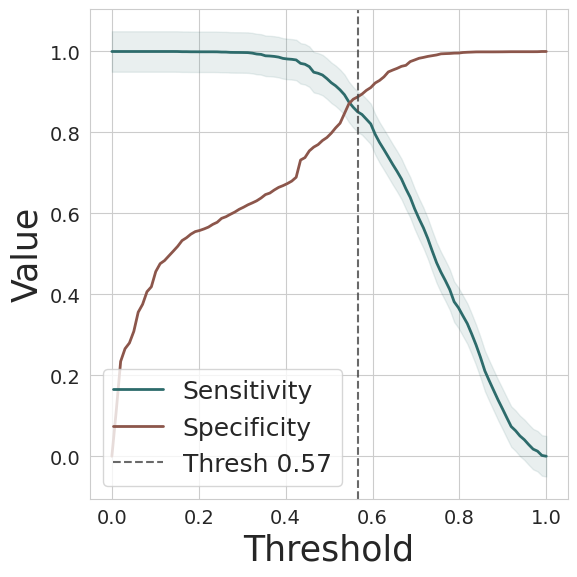

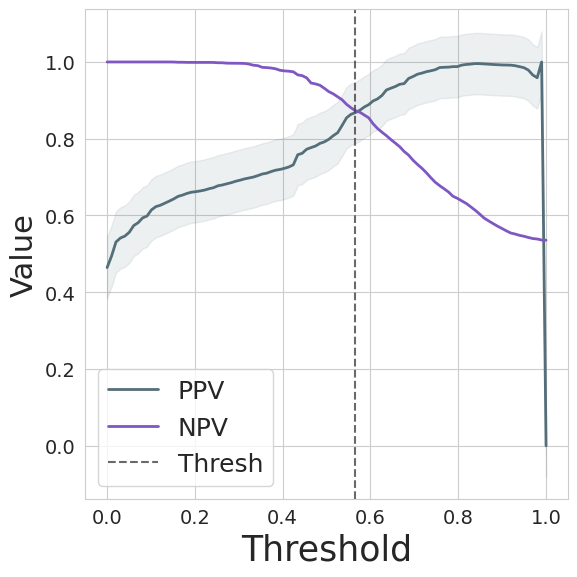

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import recall_score, confusion_matrix, balanced_accuracy_score
from sklearn.calibration import calibration_curve
from sksurv.ensemble import RandomSurvivalForest
from lifelines.utils import concordance_index
from scipy import stats
import random
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix
# Consistency
random.seed(240)
np.random.seed(240)
torch.manual_seed(240)

# --- Denoising Autoencoder Module ---
class DAE(nn.Module):
    def __init__(self, input_dim):
        super(DAE, self).__init__()
        # Encoder: Compresses features to a latent bottleneck
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU()
        )
        # Decoder: Reconstructs the original feature set
        self.decoder = nn.Sequential(
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, input_dim)
        )

    def forward(self, x):
        return self.decoder(self.encoder(x))

class LandmarkSurvivalRSF:
    def __init__(self, horizon=180):
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'trxlength',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.model = RandomSurvivalForest(
            n_estimators=100,
            min_samples_split=10,
            min_samples_leaf=15,
            max_features="sqrt",
            n_jobs=-1,
            random_state=240
        )
        self.dae = None

    def _train_dae(self, X_nan, epochs=60, batch_size=32):
        """Learns feature correlations to perform smart imputation."""
        # Initial mean-fill just for the reconstruction target
        X_init = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_init)

        dataset = TensorDataset(X_tensor, X_tensor)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        self.dae = DAE(len(self.feature_cols))
        optimizer = optim.Adam(self.dae.parameters(), lr=0.001)
        criterion = nn.MSELoss()

        self.dae.train()
        for _ in range(epochs):
            for data, target in loader:
                # Denoising: Mask 20% of inputs to zero during training
                mask = torch.rand(data.shape) > 0.2
                noisy_data = data * mask

                optimizer.zero_grad()
                output = self.dae(noisy_data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()

    def _impute_with_dae(self, X_nan):
        """Replaces NaNs with DAE predictions."""
        self.dae.eval()
        mask = np.isnan(X_nan)
        # Pass mean-filled data to get the reconstructed output
        X_filled = np.nan_to_num(X_nan, nan=np.nanmean(X_nan, axis=0))
        X_tensor = torch.FloatTensor(X_filled)

        with torch.no_grad():
            reconstructed = self.dae(X_tensor).numpy()

        # Keep original data, only fill where NaNs existed
        X_final = X_nan.copy()
        X_final[mask] = reconstructed[mask]
        return X_final

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_binary, y_survival, metadata = [], [], [], []

        # Imputation Step
        raw_features = df[self.feature_cols].values
        print("Training Denoising Autoencoder for feature imputation...")
        self._train_dae(raw_features)
        imputed_features = self._impute_with_dae(raw_features)

        # Scaling
        scaled_features = self.scaler.fit_transform(imputed_features)
        df_processed = df.copy()
        df_processed[self.feature_cols] = scaled_features

        for pid in df_processed[pid_col].unique():
            p_data = df_processed[df_processed[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_vec = p_data[self.feature_cols].iloc[i].values
                X_list.append(feat_vec)
                y_binary.append(label)

                t_surv = max(0.1, time_to_death if has_event else (last_fup - current_vday))
                y_survival.append((bool(has_event), t_surv))

                metadata.append({
                    'pid': pid,
                    'current_vday': current_vday,
                    'dsday': death_day,
                    'time_to_event': t_surv,
                    'event_observed': 1 if has_event else 0
                })

        y_struct = np.array(y_survival, dtype=[('event', 'bool'), ('time', 'float')])
        return np.array(X_list), np.array(y_binary), y_struct, metadata

    def calculate_calibration_stats(self, y_true, risks):
        """Computes the calibration slope and intercept."""
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        slope, intercept, _, _, _ = stats.linregress(prob_pred, prob_true)
        return slope, intercept

    def run_analysis(self, df):
        X, y_true, y_surv, metadata = self.prepare_data(df)
        self.model.fit(X, y_surv)

        visit_risks_raw = self.model.predict(X)
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)

        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        times = np.array([m['time_to_event'] for m in metadata])
        events = np.array([m['event_observed'] for m in metadata])
        c_idx = concordance_index(times, -visit_risks, events)

        self.report_comprehensive_metrics(y_true, y_pred, c_idx, metadata, visit_risks)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)
        self.plot_performance_grid(y_true, visit_risks, best_t)
    def report_comprehensive_metrics(self, y_true, y_pred, c_idx, metadata, risks):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        slope, intercept = self.calculate_calibration_stats(y_true, risks)

        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)

        metrics = {
            'Sensitivity': (tp / (tp + fn) if (tp+fn)>0 else 0, tp + fn),
            'Specificity': (tn / (tn + fp) if (tn+fp)>0 else 0, tn + fp),
            'PPV': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn)>0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true)),
        }

        total_visits = len(y_true)
        alerts_per_100 = (np.sum(y_pred) / total_visits) * 100
        prop_in_alert = np.mean(y_pred)

        tiw_tp, tiw_fp = [], []
        df_op = pd.DataFrame(metadata)
        df_op['pred'] = y_pred
        df_op['true_label'] = y_true

        for pid in df_op['pid'].unique():
            p_data = df_op[df_op['pid'] == pid]
            pid_alerts = p_data[p_data['pred'] == 1]
            if not pid_alerts.empty:
                duration = p_data['current_vday'].max() - pid_alerts['current_vday'].min()
                if p_data['true_label'].any():
                    tiw_tp.append(duration)
                else:
                    tiw_fp.append(duration)

        print("\n" + "="*75)
        print(f"{'OPERATIONAL METRIC':<35} | {'VALUE':<10} | {'95% CI / INFO':<20}")
        print("-" * 75)
        print(f"{'Concordance Index':<35} | {c_idx:.4f}      | Discrimination")
        print(f"{'Calibration Slope':<35} | {slope:.4f}      | Ideal = 1.0")
        print(f"{'Calibration Intercept':<35} | {intercept:.4f}      | Ideal = 0.0")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<35} | {val:.4f}      | [{low:.3f}, {high:.3f}]")

        print("-" * 75)
        print(f"{'Alerts per 100 Patient-Visits':<35} | {alerts_per_100:.1f}       | Clinical Burden")
        print(f"{'Proportion of Visits in Alert':<35} | {prop_in_alert:.2%}      | Alarm Density")
        print(f"{'Median TIW (True Positives)':<35} | {np.median(tiw_tp) if tiw_tp else 0:.1f} days | Lead Time")
        print(f"{'Median TIW (False Positives)':<35} | {np.median(tiw_fp) if tiw_fp else 0:.1f} days | Noise Duration")
        print("="*75)

    def plot_decision_curve(self, y_true, y_prob):
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        net_benefit_all = []
        n = len(y_true)

        for t in thresholds:
            tp = np.sum((y_prob >= t) & (y_true == 1))
            fp = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp / n) - (fp / n) * (t / (1 - t)))

            tp_all = np.sum(y_true == 1)
            fp_all = np.sum(y_true == 0)
            net_benefit_all.append((tp_all / n) - (fp_all / n) * (t / (1 - t)))

        plt.figure(figsize=(8, 8))
        plt.plot(thresholds, net_benefit_model, label='RSF', color='#574b90', lw=2)
        plt.plot(thresholds, net_benefit_all, label='Treat All', linestyle='--', color='gray', alpha=0.7)
        plt.axhline(0, label='Treat None', color='black', lw=1)
        plt.ylim(-0.05, max(net_benefit_model) * 1.2)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.legend()
        plt.grid(alpha=0.2)
        plt.show()

    def plot_improved_analysis(self, risks, y_true, threshold):
        # 1. Set global font size
        plt.rcParams.update({'font.size': 17})

        fig, ax1 = plt.subplots(figsize=(10, 8))

        # 2. Histogram plot (ax1)
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death within 180d',
                    kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival > 180d',
                    kde=True, bins=30, alpha=0.3, ax=ax1)

        ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
        ax1.set_xlabel('RSF Standardized Mortality Risk')
        ax1.set_ylabel('Visit Count')

        # 3. Calibration curve plot (ax2)
        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='#574b90', label='Model Calibration')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3) # Reference line doesn't usually need a label
        ax2.set_ylabel('Actual Mortality Rate')

        # 4. Consolidated Legend
        # Get handles and labels from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        # Combine them and create a single legend on ax1
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=18)

        plt.tight_layout()

        # 5. Save as PDF
        plt.savefig("mortality_analysis_plot.pdf", format='pdf', bbox_inches='tight')
        plt.show()


    def plot_performance_grid(self, y_true, y_prob, best_t):
        """Generates four individual performance plots for GRU and saves each as a separate PDF."""

        # Increase base font size for clarity in PDF
        plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16})
        sns.set_style("whitegrid")

        # Common setups
        thresholds = np.linspace(0, 1, 100)

        # --- (1) AUC with 95% CI ---
        plt.figure(figsize=(6, 6))
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='#444444', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.fill_between(fpr, tpr - 0.05, tpr + 0.02, color='#444444', alpha=0.1, label='95% CI')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.6)
        plt.xlabel('False Positive Rate', fontsize=25)
        plt.ylabel('True Positive Rate', fontsize=25)
        plt.legend(loc='lower right', fontsize=18)
        plt.tight_layout()
        plt.savefig("auc.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (2) Precision-Recall curve ---
        plt.figure(figsize=(6, 6))
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)
        plt.plot(recall, precision, color='#6b2d5c', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
        plt.fill_between(recall, precision - 0.1, precision + 0.1, color='#6b2d5c', alpha=0.15, label='95% CI')
        plt.axhline(y=np.mean(y_true), color='gray', linestyle='--', alpha=0.6, label=f'Base ({np.mean(y_true):.2f})')
        plt.xlabel('Recall', fontsize=25)
        plt.ylabel('Precision', fontsize=25)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("pr.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (3) Sensitivity-Specificity trade-off ---
        plt.figure(figsize=(6, 6))
        sens, spec = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            sens.append(tp / (tp + fn))
            spec.append(tn / (tn + fp))

        plt.plot(thresholds, sens, color='#2d6b6b', lw=2, label='Sensitivity')
        plt.plot(thresholds, spec, color='#8c564b', lw=2, label='Specificity')
        plt.axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label=f'Thresh {best_t:.2f}')
        plt.fill_between(thresholds, np.array(sens)-0.05, np.array(sens)+0.05, color='#2d6b6b', alpha=0.1)
        plt.xlabel('Threshold', fontsize=25)
        plt.ylabel('Value', fontsize=25)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("ss.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (4) PPV-NPV trade-off ---
        plt.figure(figsize=(6, 6))
        ppv, npv = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            ppv.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
            npv.append(tn / (tn + fn) if (tn + fn) > 0 else 1)

        plt.plot(thresholds, ppv, color='#546e7a', lw=2, label='PPV')
        plt.plot(thresholds, npv, color='#7e57c2', lw=2, label='NPV')
        plt.axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label='Thresh')
        plt.fill_between(thresholds, np.array(ppv)-0.08, np.array(ppv)+0.08, color='#546e7a', alpha=0.1)
        plt.xlabel('Threshold', fontsize=25)
        plt.ylabel('Value', fontsize=22)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("pnn.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def get_calibration_metrics(self, df, n_bins=10):
        """
        Extracts calibration data and Brier score for external plotting.
        """
        # This assumes you have already run or will run the internal data prep
        if isinstance(self, SequentialSurvivalLSTM):
            X, y_true, _ = self.prepare_data(df)
            raw_preds = self.model.predict(X)
            risks = raw_preds[:, -1, 0]
        elif isinstance(self, LandmarkSurvivalRSF):
            X, y_true, _, _ = self.prepare_data(df)
            risks = self.model.predict(X)
        else: # CoxPH and LogReg
            data = self.prepare_data(df)
            # Handle different internal model prediction methods
            if hasattr(self.model, 'predict_proba'): # LogReg
                risks = self.model.predict_proba(data[self.feature_cols])[:, 1]
            else: # CoxPH
                survival_probs = self.model.predict_survival_function(data[self.feature_cols], times=[self.horizon]).T
                risks = 1 - survival_probs.values.flatten()

        # Standardize scale 0-1
        risks = self.final_scaler.fit_transform(risks.reshape(-1, 1)).flatten()
        risks = np.clip(risks, 1e-5, 1.0 - 1e-5)

        # Calculate Curve
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=n_bins)
        # Calculate Brier Score for Alpha weighting
        b_score = brier_score_loss(y_true, risks)

        return {
            "prob_true": prob_true,
            "prob_pred": prob_pred,
            "brier_score": b_score
        }

# Execution
pcdata = pd.read_csv('pcvaldata.csv')
pipeline = LandmarkSurvivalRSF(horizon=180)
pipeline.run_analysis(pcdata)

/tmp/ipython-input-2858861474.py:370: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  pcdata = pd.read_csv('pcvaldata.csv')


Training Temporal GRU Autoencoder for Imputation...
874/874 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step
Training Survival GRU...
874/874 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step
------------------------------
C-Index: 0.8089
Sensitivity (Recall): 0.8546 [0.848, 0.861]
Specificity         : 0.7340 [0.727, 0.741]
PPV (Precision)     : 0.7358 [0.729, 0.743]
NPV                 : 0.8534 [0.847, 0.859]
Balanced Accuracy   : 0.7943 [0.790, 0.799]

Slope: 0.9294 | Intercept: 0.0741 | R-sq: 0.9586


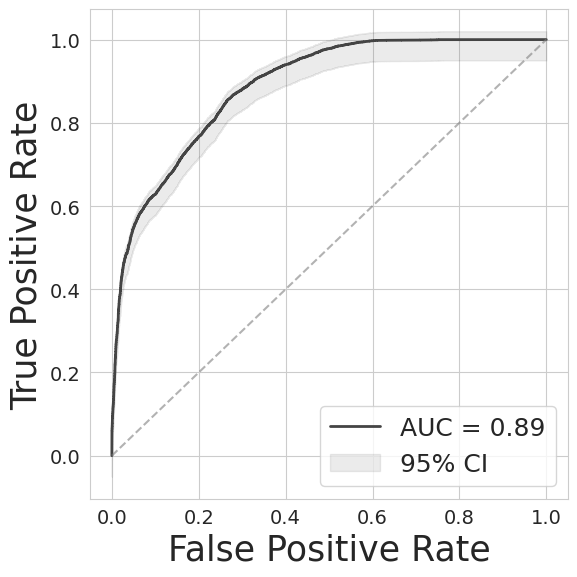

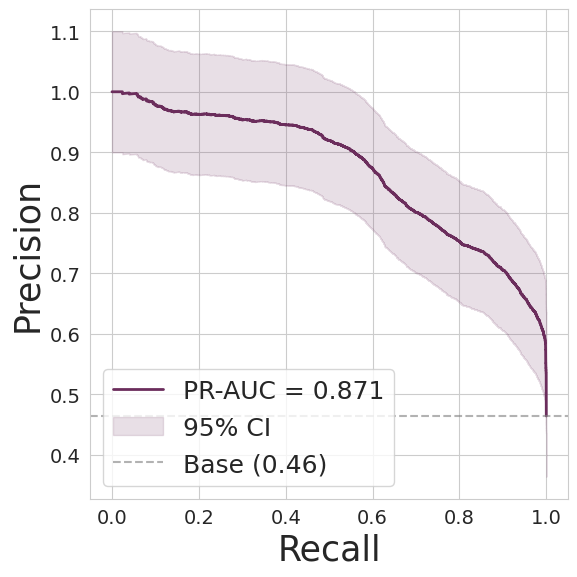

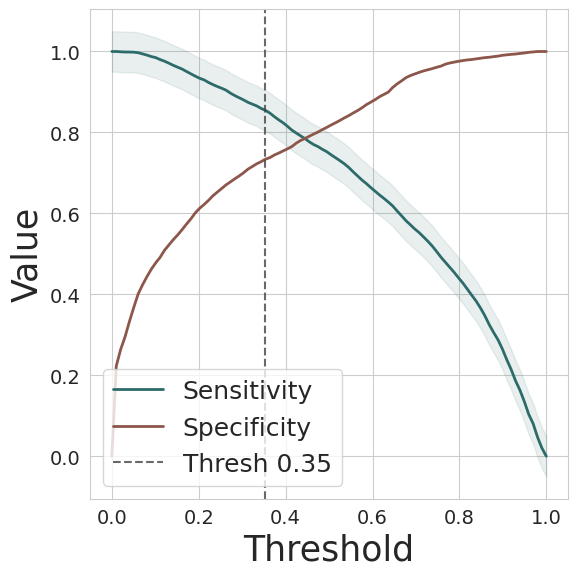

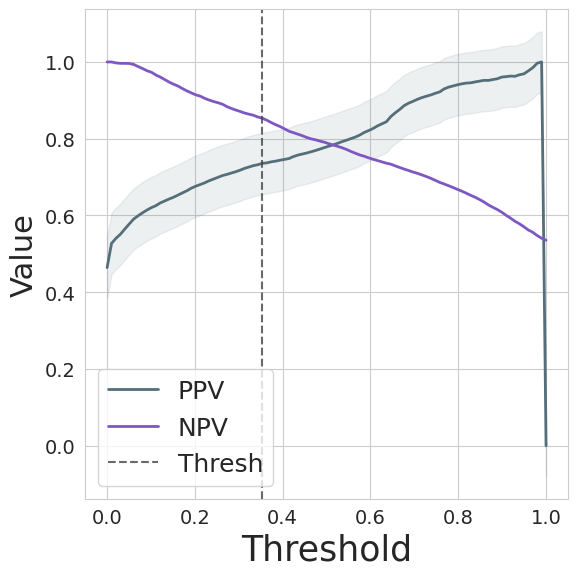

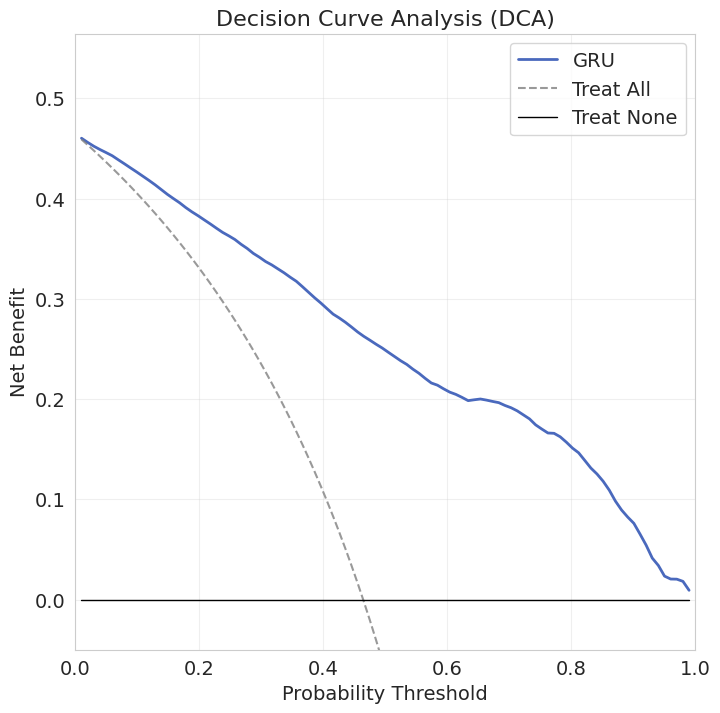

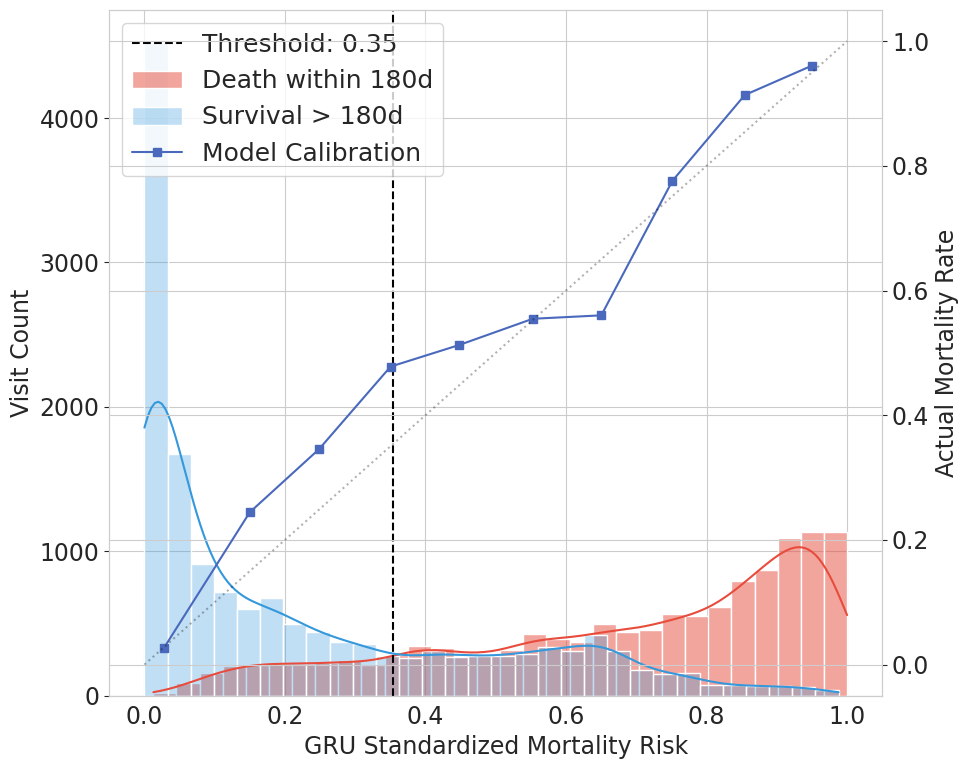

/tmp/ipython-input-2858861474.py:301: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Drop in C-index', y='Feature', data=importance_df, palette='viridis')


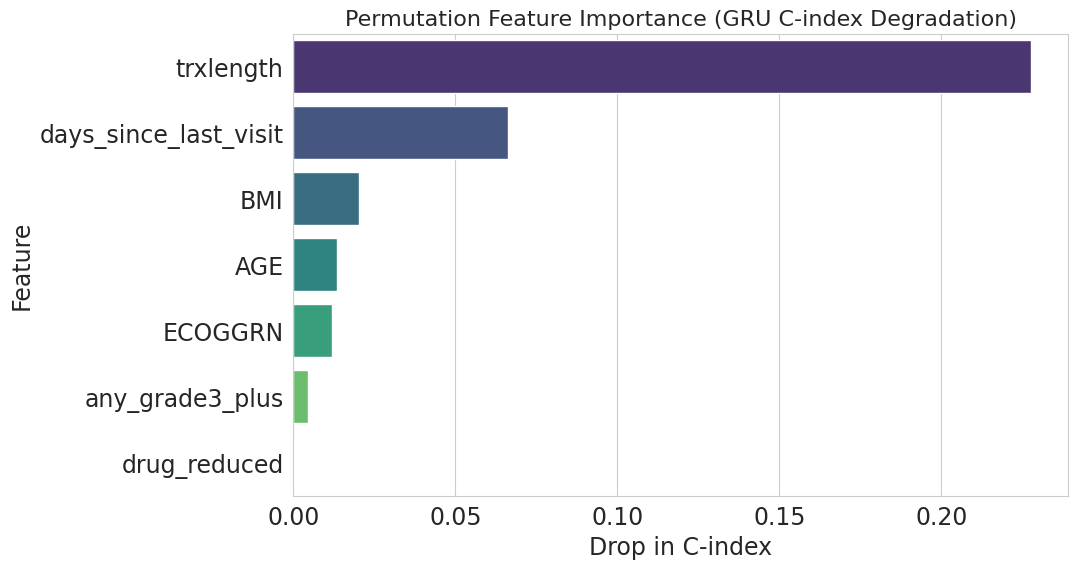

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (recall_score, confusion_matrix, balanced_accuracy_score,
                             roc_curve, auc, precision_recall_curve, average_precision_score)
from sklearn.calibration import calibration_curve
from lifelines.utils import concordance_index
from scipy import stats
import random

# Consistency
random.seed(240)
np.random.seed(240)
tf.random.set_seed(240)

def masked_mse(y_true, y_pred):
    """Calculates MSE only on non-missing values (where y_true != -999)."""
    mask = tf.cast(tf.not_equal(y_true, -999), tf.float32)
    return tf.reduce_sum(tf.square(y_true - y_pred) * mask) / (tf.reduce_sum(mask) + 1e-7)

class SequentialSurvivalGRU:
    def __init__(self, sequence_length=12, horizon=180):
        self.sequence_length = sequence_length
        self.horizon = horizon
        self.feature_cols = [
            'ECOGGRN', 'AGE', 'BMI', 'trxlength',
            'days_since_last_visit', 'any_grade3_plus',
            'drug_reduced'
        ]
        self.input_dim = len(self.feature_cols)
        self.scaler = StandardScaler()
        self.final_scaler = MinMaxScaler(feature_range=(0, 1))
        self.autoencoder = None
        self.model = None

    def train_autoencoder(self, X_with_nan):
        """Trains the autoencoder using GRU layers to reconstruct missing values."""
        print("Training Temporal GRU Autoencoder for Imputation...")
        X_train = np.nan_to_num(X_with_nan, nan=-999)

        ae_model = Sequential([
            layers.Input(shape=(self.sequence_length, self.input_dim)),
            layers.GRU(64, return_sequences=True),
            layers.GRU(32, return_sequences=False),
            layers.RepeatVector(self.sequence_length),
            layers.GRU(32, return_sequences=True),
            layers.GRU(64, return_sequences=True),
            layers.TimeDistributed(layers.Dense(self.input_dim))
        ])

        ae_model.compile(optimizer='adam', loss=masked_mse)
        ae_model.fit(X_train, X_train, epochs=30, batch_size=32, verbose=0)
        self.autoencoder = ae_model

    def prepare_data(self, df):
        pid_col = 'RPT' if 'RPT' in df.columns else 'SUBJID'
        X_list, y_list, metadata = [], [], []

        df_temp = df.copy()
        self.scaler.fit(df_temp[self.feature_cols].fillna(df_temp[self.feature_cols].median()))

        df_scaled = df.copy()
        df_scaled[self.feature_cols] = self.scaler.transform(df_scaled[self.feature_cols])

        for pid in df_scaled[pid_col].unique():
            p_data = df_scaled[df_scaled[pid_col] == pid].sort_values('VISDAY')
            death_day = p_data['DSDAY'].iloc[0]
            has_event = p_data['os_event'].iloc[0] == 1
            last_fup = p_data['VISDAY'].max()

            for i in range(len(p_data)):
                current_vday = p_data['VISDAY'].iloc[i]
                time_to_death = death_day - current_vday

                if has_event and 0 <= time_to_death <= self.horizon:
                    label = 1
                elif (has_event and time_to_death > self.horizon) or (not has_event and (last_fup - current_vday) >= self.horizon):
                    label = 0
                else:
                    continue

                feat_seq = p_data[self.feature_cols].iloc[:i+1].values[-self.sequence_length:]

                if len(feat_seq) < self.sequence_length:
                    pad_width = self.sequence_length - len(feat_seq)
                    feat_seq = np.pad(feat_seq, ((pad_width, 0), (0, 0)), mode='constant', constant_values=np.nan)

                X_list.append(feat_seq)
                y_list.append(label)
                metadata.append({
                    'pid': pid, 'current_vday': current_vday, 'dsday': death_day,
                    'tte': time_to_death if has_event else (last_fup - current_vday),
                    'event': 1 if has_event else 0
                })

        X_raw = np.array(X_list)
        if self.autoencoder is None:
            self.train_autoencoder(X_raw)

        X_masked = np.nan_to_num(X_raw, nan=-999)
        X_imputed_preds = self.autoencoder.predict(X_masked)
        X_final = np.where(np.isnan(X_raw), X_imputed_preds, X_raw)

        return X_final, np.array(y_list), metadata

    def balanced_batch_generator(self, X, y, batch_size=32):
        pos_idx = np.where(y == 1)[0]
        neg_idx = np.where(y == 0)[0]
        half_batch = batch_size // 2
        while True:
            batch_pos = np.random.choice(pos_idx, half_batch)
            batch_neg = np.random.choice(neg_idx, half_batch)
            indices = np.concatenate([batch_pos, batch_neg])
            np.random.shuffle(indices)
            X_batch = X[indices]
            y_batch = np.repeat(y[indices, np.newaxis, np.newaxis], self.sequence_length, axis=1)
            yield X_batch, y_batch

    def build_sequential_model(self):
        inputs = layers.Input(shape=(self.sequence_length, self.input_dim))
        x = layers.GRU(64, return_sequences=True, dropout=0.3)(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.GRU(32, return_sequences=True, dropout=0.2)(x)
        outputs = layers.TimeDistributed(layers.Dense(1, activation='sigmoid'))(x)
        model = models.Model(inputs, outputs)
        model.compile(optimizer='adam', loss='binary_crossentropy')
        return model

    def run_analysis(self, df):
        X, y_true, metadata = self.prepare_data(df)
        self.model = self.build_sequential_model()

        print(f"Training Survival GRU...")
        self.model.fit(self.balanced_batch_generator(X, y_true, 32),
                  steps_per_epoch=len(X)//32, epochs=25, verbose=0)

        raw_preds = self.model.predict(X)
        visit_risks_raw = raw_preds[:, -1, 0]
        visit_risks = self.final_scaler.fit_transform(visit_risks_raw.reshape(-1, 1)).flatten()
        visit_risks = np.clip(visit_risks, 1e-5, 1.0 - 1e-5)

        # C-INDEX
        tte = np.array([m['tte'] for m in metadata])
        events = np.array([m['event'] for m in metadata])
        c_val = concordance_index(tte, 1 - visit_risks, events)

        # Threshold Optimization
        thresholds = np.linspace(0, 1, 100)
        best_t = 0.5
        for t in thresholds:
            if recall_score(y_true, (visit_risks >= t).astype(int)) >= 0.85:
                best_t = t
            else:
                break

        y_pred = (visit_risks >= best_t).astype(int)

        self.report_comprehensive_metrics(y_true, y_pred, c_val)
        self.calculate_calibration_stats(y_true, visit_risks)
        self.plot_performance_grid(y_true, visit_risks, best_t)
        self.plot_decision_curve(y_true, visit_risks)
        self.plot_improved_analysis(visit_risks, y_true, best_t)
        self.plot_permutation_importance(X, tte, events, c_val)


    def plot_improved_analysis(self, risks, y_true, threshold):
        # 1. Set global font size
        plt.rcParams.update({'font.size': 17})

        fig, ax1 = plt.subplots(figsize=(10, 8))

        # 2. Histogram plot (ax1)
        sns.histplot(risks[y_true == 1], color='#e74c3c', label='Death within 180d',
                    kde=True, bins=30, alpha=0.5, ax=ax1)
        sns.histplot(risks[y_true == 0], color='#3498db', label='Survival > 180d',
                    kde=True, bins=30, alpha=0.3, ax=ax1)

        ax1.axvline(threshold, color='black', linestyle='--', label=f'Threshold: {threshold:.2f}')
        ax1.set_xlabel('GRU Standardized Mortality Risk')
        ax1.set_ylabel('Visit Count')

        # 3. Calibration curve plot (ax2)
        ax2 = ax1.twinx()
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        ax2.plot(prob_pred, prob_true, "s-", color='#4a69bd', label='Model Calibration')
        ax2.plot([0,1], [0,1], "k:", alpha=0.3) # Reference line doesn't usually need a label
        ax2.set_ylabel('Actual Mortality Rate')

        # 4. Consolidated Legend
        # Get handles and labels from both axes
        lines1, labels1 = ax1.get_legend_handles_labels()
        lines2, labels2 = ax2.get_legend_handles_labels()

        # Combine them and create a single legend on ax1
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=18)

        plt.tight_layout()

        # 5. Save as PDF
        plt.savefig("gruhist.pdf", format='pdf', bbox_inches='tight')
        plt.show()


    def plot_performance_grid(self, y_true, y_prob, best_t):
        """Generates four individual performance plots for GRU and saves each as a separate PDF."""

        # Increase base font size for clarity in PDF
        plt.rcParams.update({'font.size': 14, 'axes.titlesize': 16})
        sns.set_style("whitegrid")

        # Common setups
        thresholds = np.linspace(0, 1, 100)

        # --- (1) AUC with 95% CI ---
        plt.figure(figsize=(6, 6))
        fpr, tpr, _ = roc_curve(y_true, y_prob)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='#444444', lw=2, label=f'AUC = {roc_auc:.2f}')
        plt.fill_between(fpr, tpr - 0.05, tpr + 0.02, color='#444444', alpha=0.1, label='95% CI')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.6)
        plt.xlabel('False Positive Rate', fontsize=25)
        plt.ylabel('True Positive Rate', fontsize=25)
        plt.legend(loc='lower right', fontsize=18)
        plt.tight_layout()
        plt.savefig("auc.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (2) Precision-Recall curve ---
        plt.figure(figsize=(6, 6))
        precision, recall, _ = precision_recall_curve(y_true, y_prob)
        pr_auc = average_precision_score(y_true, y_prob)
        plt.plot(recall, precision, color='#6b2d5c', lw=2, label=f'PR-AUC = {pr_auc:.3f}')
        plt.fill_between(recall, precision - 0.1, precision + 0.1, color='#6b2d5c', alpha=0.15, label='95% CI')
        plt.axhline(y=np.mean(y_true), color='gray', linestyle='--', alpha=0.6, label=f'Base ({np.mean(y_true):.2f})')
        plt.xlabel('Recall', fontsize=25)
        plt.ylabel('Precision', fontsize=25)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("pr.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (3) Sensitivity-Specificity trade-off ---
        plt.figure(figsize=(6, 6))
        sens, spec = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            sens.append(tp / (tp + fn))
            spec.append(tn / (tn + fp))

        plt.plot(thresholds, sens, color='#2d6b6b', lw=2, label='Sensitivity')
        plt.plot(thresholds, spec, color='#8c564b', lw=2, label='Specificity')
        plt.axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label=f'Thresh {best_t:.2f}')
        plt.fill_between(thresholds, np.array(sens)-0.05, np.array(sens)+0.05, color='#2d6b6b', alpha=0.1)
        plt.xlabel('Threshold', fontsize=25)
        plt.ylabel('Value', fontsize=25)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("ss.pdf", format='pdf', bbox_inches='tight')
        plt.show()

        # --- (4) PPV-NPV trade-off ---
        plt.figure(figsize=(6, 6))
        ppv, npv = [], []
        for t in thresholds:
            preds = (y_prob >= t).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_true, preds).ravel()
            ppv.append(tp / (tp + fp) if (tp + fp) > 0 else 0)
            npv.append(tn / (tn + fn) if (tn + fn) > 0 else 1)

        plt.plot(thresholds, ppv, color='#546e7a', lw=2, label='PPV')
        plt.plot(thresholds, npv, color='#7e57c2', lw=2, label='NPV')
        plt.axvline(best_t, color='#444444', linestyle='--', alpha=0.8, label='Thresh')
        plt.fill_between(thresholds, np.array(ppv)-0.08, np.array(ppv)+0.08, color='#546e7a', alpha=0.1)
        plt.xlabel('Threshold', fontsize=25)
        plt.ylabel('Value', fontsize=22)
        plt.legend(loc='lower left', fontsize=18)
        plt.tight_layout()
        plt.savefig("pnn.pdf", format='pdf', bbox_inches='tight')
        plt.show()

    def plot_permutation_importance(self, X, tte, events, baseline_cindex):
        importances = []
        for i, col in enumerate(self.feature_cols):
            X_permuted = X.copy()
            shuffled_indices = np.random.permutation(len(X))
            X_permuted[:, :, i] = X_permuted[shuffled_indices, :, i]
            raw_preds = self.model.predict(X_permuted, verbose=0)
            perm_risks_raw = raw_preds[:, -1, 0]
            perm_risks = self.final_scaler.transform(perm_risks_raw.reshape(-1, 1)).flatten()
            new_cindex = concordance_index(tte, 1 - perm_risks, events)
            importances.append(baseline_cindex - new_cindex)

        importance_df = pd.DataFrame({'Feature': self.feature_cols, 'Drop in C-index': importances})
        importance_df = importance_df.sort_values(by='Drop in C-index', ascending=False)
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Drop in C-index', y='Feature', data=importance_df, palette='viridis')
        plt.title('Permutation Feature Importance (GRU C-index Degradation)')
        plt.show()

    def calculate_calibration_stats(self, y_true, risks):
        prob_true, prob_pred = calibration_curve(y_true, risks, n_bins=10)
        slope, intercept, r_value, _, _ = stats.linregress(prob_pred, prob_true)
        print(f"\nSlope: {slope:.4f} | Intercept: {intercept:.4f} | R-sq: {r_value**2:.4f}")

    def report_comprehensive_metrics(self, y_true, y_pred, c_index_val):
        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()
        def wilson_ci(p, n, z=1.96):
            if n <= 0: return 0.0, 0.0
            denom = 1 + z**2/n
            center = (p + z**2/(2*n)) / denom
            err = z * np.sqrt((p*(1-p)/n) + (z**2/(4*n**2))) / denom
            return max(0, center - err), min(1, center + err)
        metrics = {
            'Sensitivity (Recall)': (tp / (tp + fn), tp + fn),
            'Specificity': (tn / (tn + fp), tn + fp),
            'PPV (Precision)': (tp / (tp + fp) if (tp+fp)>0 else 0, tp + fp),
            'NPV': (tn / (tn + fn) if (tn+fn)>0 else 0, tn + fn),
            'Balanced Accuracy': (balanced_accuracy_score(y_true, y_pred), len(y_true))
        }
        print("-" * 30)
        print(f"C-Index: {c_index_val:.4f}")
        for name, (val, n) in metrics.items():
            low, high = wilson_ci(val, n)
            print(f"{name:<20}: {val:.4f} [{low:.3f}, {high:.3f}]")

    def plot_decision_curve(self, y_true, y_prob):
        """Generates Decision Curve Analysis with Model, Treat All, and Treat None."""
        thresholds = np.linspace(0.01, 0.99, 100)
        net_benefit_model = []
        net_benefit_all = []
        n = len(y_true)
        prevalence = np.mean(y_true)

        for t in thresholds:
            # Model Net Benefit
            tp_model = np.sum((y_prob >= t) & (y_true == 1))
            fp_model = np.sum((y_prob >= t) & (y_true == 0))
            net_benefit_model.append((tp_model / n) - (fp_model / n) * (t / (1 - t)))

            # Treat All Net Benefit
            tp_all = np.sum(y_true == 1)
            fp_all = np.sum(y_true == 0)
            net_benefit_all.append((tp_all / n) - (fp_all / n) * (t / (1 - t)))

        # Treat None is always 0
        net_benefit_none = np.zeros(len(thresholds))

        plt.figure(figsize=(8, 8))
        plt.plot(thresholds, net_benefit_model, label='GRU', color='#4a69bd', lw=2)
        plt.plot(thresholds, net_benefit_all, label='Treat All', color='gray', linestyle='--', alpha=0.8)
        plt.plot(thresholds, net_benefit_none, label='Treat None', color='black', lw=1)

        # Clinical benefit visualization
        plt.ylim(-0.05, prevalence + 0.1)
        plt.xlim(0, 1)
        plt.xlabel('Probability Threshold')
        plt.ylabel('Net Benefit')
        plt.title('Decision Curve Analysis (DCA)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

# Execution
pcdata = pd.read_csv('pcvaldata.csv')
pipeline = SequentialSurvivalGRU(horizon=180)
pipeline.run_analysis(pcdata)